<a href="https://colab.research.google.com/github/jiin-son/credit_card_fraud_detection/blob/main/NBA_Machine_Learning_(xgboost).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.3f}'.format
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score

In [3]:
!pip install xgboost
import xgboost as xgb

In [4]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.8 MB/s eta 0:00:00


In [5]:
from google.colab import files
uploaded = files.upload()

Saving final_df.csv to final_df.csv


In [6]:
final_df = pd.read_csv('final_df.csv')

In [7]:
# Function to convert time to total minutes
def time_to_minutes(time_str):
    try:
        minutes, seconds = time_str.split(':')
        minutes = float(minutes)  # Handle decimal minutes
        seconds = int(seconds)  # Handle seconds
        return minutes + seconds / 60
    except ValueError:
        return None  # Handle invalid formats gracefully

# Apply the function
final_df['TOTAL_MIN'] = final_df['MIN'].apply(time_to_minutes)

In [8]:
# remove records that MIN is less than 1 minute
final_df = final_df[final_df['TOTAL_MIN'] >= 1]

In [9]:
final_df

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,POSITION,HEIGHT,WEIGHT,YEARS_IN_LEAGUE,GAME_DATE,GAME_MIN,W,HOME,OVERTIME,REST_DAYS,MIN_LAST_SEASON,FGM_LAST_SEASON,FGA_LAST_SEASON,FG_PCT_LAST_SEASON,FG3M_LAST_SEASON,FG3A_LAST_SEASON,FG3_PCT_LAST_SEASON,FTM_LAST_SEASON,FTA_LAST_SEASON,FT_PCT_LAST_SEASON,OREB_LAST_SEASON,DREB_LAST_SEASON,REB_LAST_SEASON,AST_LAST_SEASON,STL_LAST_SEASON,BLK_LAST_SEASON,TOV_LAST_SEASON,PF_LAST_SEASON,PTS_LAST_SEASON,TRADED_LAST_SEASON,PLAYER_AGE,TRADED_THIS_SEASON,Height_in_Inches,POS_G,POS_F,POS_C,POS_FC,POS_GF,POS_CF,POS_FG,START_POS_F,START_POS_G,START_POS_C,TEAM_GSW,TEAM_OKC,TEAM_CHI,TEAM_MEM,TEAM_ORL,TEAM_SAS,TEAM_DAL,TEAM_TOR,TEAM_LAC,TEAM_PHI,TEAM_SAC,TEAM_BOS,TEAM_IND,TEAM_DET,TEAM_MIL,TEAM_CLE,TEAM_WAS,TEAM_CHA,TEAM_HOU,TEAM_DEN,TEAM_PHX,TEAM_MIA,TEAM_UTA,TEAM_LAL,TEAM_POR,TEAM_MIN,TEAM_NYK,TEAM_BKN,TEAM_ATL,TEAM_NOP,TOTAL_MIN
0,22400487,1610612738,BOS,Boston,1627759,Jaylen Brown,Jaylen,F,NaN,39.000000:37,8.000,19.000,0.421,1.000,6.000,0.167,4.000,4.000,1.000,0.000,3.000,3.000,3.000,1.000,1.000,3.000,2.000,21.000,-7.000,Guard-Forward,6-6,223.000,9.000,2025-01-05,240.000,0.000,0.000,0.000,2.000,2343.000,627.000,1256.000,0.499,145.000,410.000,0.354,211.000,300.000,0.703,84.000,303.000,387.000,249.000,83.000,37.000,166.000,185.000,1610.000,0.000,28.000,0,78,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39.617
1,22400487,1610612738,BOS,Boston,1628369,Jayson Tatum,Jayson,F,NaN,38.000000:52,7.000,17.000,0.412,2.000,6.000,0.333,10.000,12.000,0.833,1.000,9.000,10.000,1.000,2.000,0.000,2.000,1.000,26.000,-12.000,Forward-Guard,6-8,210.000,8.000,2025-01-05,240.000,0.000,0.000,0.000,2.000,2645.000,672.000,1426.000,0.471,229.000,609.000,0.376,414.000,497.000,0.833,67.000,534.000,601.000,364.000,75.000,43.000,188.000,145.000,1987.000,0.000,26.000,0,80,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38.867
2,22400487,1610612738,BOS,Boston,204001,Kristaps Porziņģis,Kristaps,C,NaN,29.000000:19,6.000,12.000,0.500,1.000,6.000,0.167,6.000,6.000,1.000,4.000,5.000,9.000,1.000,1.000,0.000,4.000,5.000,19.000,-17.000,Forward-Center,7-2,240.000,10.000,2025-01-05,240.000,0.000,0.000,0.000,2.000,1690.000,388.000,752.000,0.516,110.000,293.000,0.375,259.000,302.000,0.858,97.000,312.000,409.000,115.000,42.000,111.000,89.000,156.000,1145.000,0.000,29.000,0,86,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29.317
3,22400487,1610612738,BOS,Boston,1628401,Derrick White,Derrick,G,NaN,37.000000:16,4.000,13.000,0.308,2.000,11.000,0.182,1.000,2.000,0.500,0.000,4.000,4.000,4.000,1.000,3.000,3.000,1.000,11.000,-8.000,Guard,6-4,190.000,8.000,2025-01-05,240.000,0.000,0.000,0.000,2.000,2381.000,387.000,839.000,0.461,196.000,495.000,0.396,137.000,152.000,0.901,51.000,259.000,310.000,377.000,74.000,87.000,112.000,152.000,1107.000,0.000,30.000,0,76,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.267
4,22400487,1610612738,BOS,Boston,201950,Jrue Holiday,Jrue,G,NaN,33.000000:49,1.000,6.000,0.167,0.000,4.000,0.000,0.000,0.000,0.000,3.000,5.000,8.000,6.000,0.000,0.000,2.000,4.000,2.000,-11.000,Guard,6-4,205.000,16.000,2025-01-05,240.000,0.000,0.000,0.000,2.000,2263.000,331.000,689.000,0.480,138.000,322.000,0.429,60.000,72.000,0.833,84.000,289.000,373.000,333.000,61.000,53.000,124.000,108.000,860.000,0.000,34.000,0,76,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33.817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [10]:
from google.colab import files
uploaded = files.upload()

Saving all_teams_gamelog_df.csv to all_teams_gamelog_df.csv


In [11]:
teams_gamelog_df = pd.read_csv('all_teams_gamelog_df.csv')

In [12]:
teams_gamelog_df

,Team_ID,Game_ID,GAME_DATE,MATCHUP,WL,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,TEAM_NAME
0,1610612737,22400486,"JAN 04, 2025",ATL @ LAC,L,18.000,18.000,0.500,240,38,88,0.432,16,46,0.348,13,17,0.765,8,35,43,30,11,4,22,12,105,Atlanta Hawks
1,1610612737,22400477,"JAN 03, 2025",ATL @ LAL,L,18.000,17.000,0.514,240,41,100,0.410,6,34,0.176,14,18,0.778,13,26,39,22,10,3,8,22,102,Atlanta Hawks
2,1610612737,22400461,"JAN 01, 2025",ATL @ DEN,L,18.000,16.000,0.529,240,45,100,0.450,16,46,0.348,14,21,0.667,12,32,44,34,10,5,13,16,120,Atlanta Hawks
3,1610612737,22400438,"DEC 29, 2024",ATL @ TOR,W,18.000,15.000,0.545,240,46,95,0.484,18,45,0.400,26,35,0.743,14,26,40,30,22,8,14,19,136,Atlanta Hawks
4,1610612737,22400427,"DEC 28, 2024",ATL vs. MIA,W,17.000,15.000,0.531,240,44,86,0.512,15,37,0.405,17,22,0.773,9,38,47,34,7,2,11,16,120,Atlanta Hawks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,1610612766,22400132,"NOV 01, 2024",CHA vs. BOS,L,2.000,3.000,0.400,240,42,91,0.462,19,48,0.396,6,12,0.500,12,30,42,20,5,5,14,26,109,Charlotte Hornets
1033,1610612766,22400117,"OCT 30, 2024",CHA vs. TOR,W,2.000,2.000,0.500,240,49,94,0.521,20,45,0.444,20,25,0.800,14,24,38,31,9,8,15,24,138,Charlotte Hornets
1034,1610612766,22400088,"OCT 26, 2024",CHA vs. MIA,L,1.000,2.000,0.333,240,39,89,0.438,13,41,0.317,15,21,0.714,15,31,46,20,6,5,17,24,106,Charlotte Hornets
1035,1610612766,22400079,"OCT 25, 2024",CHA @ ATL,L,1.000,1.000,0.500,240,37,96,0.385,21,51,0.412,25,31,0.806,22,31,53,22,7,4,17,28,120,Charlotte Hornets


In [13]:
# create a column that shows win streak for the previous  GAME_DATE (one game lag) for each Team_ID and Game_ID

# Sort the DataFrame by Team_ID and GAME_DATE
df = teams_gamelog_df.sort_values(['Team_ID', 'GAME_DATE'])

# Group by Team_ID
grouped = df.groupby('Team_ID')

# Function to calculate win streaks
def calculate_win_streak(group):
    win_streak = []
    current_streak = 0
    for i, row in group.iterrows():
      if row['WL'] == 'W':
        current_streak += 1
      else:
        current_streak = 0
      win_streak.append(current_streak)
    group['win_streak'] = win_streak
    return group

# Apply the function to each group
df = grouped.apply(calculate_win_streak).reset_index(drop=True)

# Shift the win streak column to create a one-game lag
df['previous_game_win_streak'] = df.groupby('Team_ID')['win_streak'].shift(1)

# Fill NaN values with 0 (for the first game of each team)
df['previous_game_win_streak'] = df['previous_game_win_streak'].fillna(0)


<ipython-input-13-4c3124eb2296>:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = grouped.apply(calculate_win_streak).reset_index(drop=True)


In [14]:
df

,Team_ID,Game_ID,GAME_DATE,MATCHUP,WL,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,TEAM_NAME,win_streak,previous_game_win_streak
0,1610612737,22400315,"DEC 02, 2024",ATL vs. NOP,W,11.000,11.000,0.500,240,49,96,0.510,10,38,0.263,16,20,0.800,11,40,51,30,12,4,18,15,124,Atlanta Hawks,1,0.000
1,1610612737,22400323,"DEC 04, 2024",ATL @ MIL,W,12.000,11.000,0.522,240,45,102,0.441,9,32,0.281,20,22,0.909,15,39,54,29,16,3,11,25,119,Atlanta Hawks,2,1.000
2,1610612737,22400334,"DEC 06, 2024",ATL vs. LAL,W,13.000,11.000,0.542,265,50,100,0.500,17,40,0.425,17,22,0.773,11,37,48,40,10,5,17,24,134,Atlanta Hawks,3,2.000
3,1610612737,22400350,"DEC 08, 2024",ATL vs. DEN,L,13.000,12.000,0.520,240,41,101,0.406,9,40,0.225,20,27,0.741,19,26,45,26,12,2,12,22,111,Atlanta Hawks,0,3.000
4,1610612737,22401202,"DEC 11, 2024",ATL @ NYK,W,14.000,12.000,0.538,240,43,104,0.413,9,31,0.290,13,20,0.650,22,36,58,27,5,7,10,13,108,Atlanta Hawks,1,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,1610612766,22400300,"NOV 30, 2024",CHA vs. ATL,L,6.000,14.000,0.300,240,35,94,0.372,18,48,0.375,16,19,0.842,18,27,45,23,13,6,14,23,104,Charlotte Hornets,0,0.000
1033,1610612766,22400068,"OCT 23, 2024",CHA @ HOU,W,1.000,0.000,1.000,240,38,85,0.447,15,39,0.385,19,24,0.792,15,41,56,20,6,10,16,21,110,Charlotte Hornets,1,0.000
1034,1610612766,22400079,"OCT 25, 2024",CHA @ ATL,L,1.000,1.000,0.500,240,37,96,0.385,21,51,0.412,25,31,0.806,22,31,53,22,7,4,17,28,120,Charlotte Hornets,0,1.000
1035,1610612766,22400088,"OCT 26, 2024",CHA vs. MIA,L,1.000,2.000,0.333,240,39,89,0.438,13,41,0.317,15,21,0.714,15,31,46,20,6,5,17,24,106,Charlotte Hornets,0,0.000


In [15]:
# prompt: convert all the variable name of df to upper case

# Rename columns to uppercase
df = df.rename(columns=str.upper)


In [16]:
# prompt: left join df to the final_df table

# Merge the two dataframes
final_df = pd.merge(final_df, df[['TEAM_ID', 'GAME_ID', 'PREVIOUS_GAME_WIN_STREAK']], on=['TEAM_ID', 'GAME_ID'], how='left')

# Display the updated DataFrame
final_df


,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,POSITION,HEIGHT,WEIGHT,YEARS_IN_LEAGUE,GAME_DATE,GAME_MIN,W,HOME,OVERTIME,REST_DAYS,MIN_LAST_SEASON,FGM_LAST_SEASON,FGA_LAST_SEASON,FG_PCT_LAST_SEASON,FG3M_LAST_SEASON,FG3A_LAST_SEASON,FG3_PCT_LAST_SEASON,FTM_LAST_SEASON,FTA_LAST_SEASON,FT_PCT_LAST_SEASON,OREB_LAST_SEASON,DREB_LAST_SEASON,REB_LAST_SEASON,AST_LAST_SEASON,STL_LAST_SEASON,BLK_LAST_SEASON,TOV_LAST_SEASON,PF_LAST_SEASON,PTS_LAST_SEASON,TRADED_LAST_SEASON,PLAYER_AGE,TRADED_THIS_SEASON,Height_in_Inches,POS_G,POS_F,POS_C,POS_FC,POS_GF,POS_CF,POS_FG,START_POS_F,START_POS_G,START_POS_C,TEAM_GSW,TEAM_OKC,TEAM_CHI,TEAM_MEM,TEAM_ORL,TEAM_SAS,TEAM_DAL,TEAM_TOR,TEAM_LAC,TEAM_PHI,TEAM_SAC,TEAM_BOS,TEAM_IND,TEAM_DET,TEAM_MIL,TEAM_CLE,TEAM_WAS,TEAM_CHA,TEAM_HOU,TEAM_DEN,TEAM_PHX,TEAM_MIA,TEAM_UTA,TEAM_LAL,TEAM_POR,TEAM_MIN,TEAM_NYK,TEAM_BKN,TEAM_ATL,TEAM_NOP,TOTAL_MIN,PREVIOUS_GAME_WIN_STREAK
0,22400487,1610612738,BOS,Boston,1627759,Jaylen Brown,Jaylen,F,NaN,39.000000:37,8.000,19.000,0.421,1.000,6.000,0.167,4.000,4.000,1.000,0.000,3.000,3.000,3.000,1.000,1.000,3.000,2.000,21.000,-7.000,Guard-Forward,6-6,223.000,9.000,2025-01-05,240.000,0.000,0.000,0.000,2.000,2343.000,627.000,1256.000,0.499,145.000,410.000,0.354,211.000,300.000,0.703,84.000,303.000,387.000,249.000,83.000,37.000,166.000,185.000,1610.000,0.000,28.000,0,78,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39.617,3.000
1,22400487,1610612738,BOS,Boston,1628369,Jayson Tatum,Jayson,F,NaN,38.000000:52,7.000,17.000,0.412,2.000,6.000,0.333,10.000,12.000,0.833,1.000,9.000,10.000,1.000,2.000,0.000,2.000,1.000,26.000,-12.000,Forward-Guard,6-8,210.000,8.000,2025-01-05,240.000,0.000,0.000,0.000,2.000,2645.000,672.000,1426.000,0.471,229.000,609.000,0.376,414.000,497.000,0.833,67.000,534.000,601.000,364.000,75.000,43.000,188.000,145.000,1987.000,0.000,26.000,0,80,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38.867,3.000
2,22400487,1610612738,BOS,Boston,204001,Kristaps Porziņģis,Kristaps,C,NaN,29.000000:19,6.000,12.000,0.500,1.000,6.000,0.167,6.000,6.000,1.000,4.000,5.000,9.000,1.000,1.000,0.000,4.000,5.000,19.000,-17.000,Forward-Center,7-2,240.000,10.000,2025-01-05,240.000,0.000,0.000,0.000,2.000,1690.000,388.000,752.000,0.516,110.000,293.000,0.375,259.000,302.000,0.858,97.000,312.000,409.000,115.000,42.000,111.000,89.000,156.000,1145.000,0.000,29.000,0,86,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29.317,3.000
3,22400487,1610612738,BOS,Boston,1628401,Derrick White,Derrick,G,NaN,37.000000:16,4.000,13.000,0.308,2.000,11.000,0.182,1.000,2.000,0.500,0.000,4.000,4.000,4.000,1.000,3.000,3.000,1.000,11.000,-8.000,Guard,6-4,190.000,8.000,2025-01-05,240.000,0.000,0.000,0.000,2.000,2381.000,387.000,839.000,0.461,196.000,495.000,0.396,137.000,152.000,0.901,51.000,259.000,310.000,377.000,74.000,87.000,112.000,152.000,1107.000,0.000,30.000,0,76,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.267,3.000
4,22400487,1610612738,BOS,Boston,201950,Jrue Holiday,Jrue,G,NaN,33.000000:49,1.000,6.000,0.167,0.000,4.000,0.000,0.000,0.000,0.000,3.000,5.000,8.000,6.000,0.000,0.000,2.000,4.000,2.000,-11.000,Guard,6-4,205.000,16.000,2025-01-05,240.000,0.000,0.000,0.000,2.000,2263.000,331.000,689.000,0.480,138.000,322.000,0.429,60.000,72.000,0.833,84.000,289.000,373.000,333.000,61.000,53.000,124.000,108.000,860.000,0.000,34.000,0,76,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33.817,3.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [17]:
# Final Dataset
prep_df = final_df[[
    # identifier
    'GAME_ID', 'PLAYER_ID',

    # game
    'HOME', 'OVERTIME', 'REST_DAYS', 'PREVIOUS_GAME_WIN_STREAK',

    # boxscore
    'FG_PCT', 'FT_PCT',
    'REB', 'AST', 'STL', 'BLK', 'TO', 'PF',

    # player metadata
    'Height_in_Inches', 'YEARS_IN_LEAGUE',

    # last season data
    'FG_PCT_LAST_SEASON',
    'FT_PCT_LAST_SEASON',
    'REB_LAST_SEASON',
    'AST_LAST_SEASON',
    'STL_LAST_SEASON',
    'BLK_LAST_SEASON',
    'TOV_LAST_SEASON',
    'PF_LAST_SEASON',
    'TRADED_LAST_SEASON',

    # this season data
    'PLAYER_AGE',
    'TRADED_THIS_SEASON',
    'POS_G', 'POS_F', 'POS_C', 'POS_FC', 'POS_GF', 'POS_CF', 'POS_FG',
    'TEAM_GSW', 'TEAM_OKC', 'TEAM_CHI', 'TEAM_MEM', 'TEAM_ORL', 'TEAM_SAS',
    'TEAM_DAL', 'TEAM_TOR', 'TEAM_LAC', 'TEAM_PHI', 'TEAM_SAC', 'TEAM_BOS',
    'TEAM_IND', 'TEAM_DET', 'TEAM_MIL', 'TEAM_CLE', 'TEAM_WAS', 'TEAM_CHA',
    'TEAM_HOU', 'TEAM_DEN', 'TEAM_PHX', 'TEAM_MIA', 'TEAM_UTA', 'TEAM_LAL',
    'TEAM_POR', 'TEAM_MIN', 'TEAM_NYK', 'TEAM_BKN', 'TEAM_ATL', 'TEAM_NOP',
    # potential opportunity to use these team segment to have tailored strategy to win the game

    # response variable
    'W']]
prep_df

,GAME_ID,PLAYER_ID,HOME,OVERTIME,REST_DAYS,PREVIOUS_GAME_WIN_STREAK,FG_PCT,FT_PCT,REB,AST,STL,BLK,TO,PF,Height_in_Inches,YEARS_IN_LEAGUE,FG_PCT_LAST_SEASON,FT_PCT_LAST_SEASON,REB_LAST_SEASON,AST_LAST_SEASON,STL_LAST_SEASON,BLK_LAST_SEASON,TOV_LAST_SEASON,PF_LAST_SEASON,TRADED_LAST_SEASON,PLAYER_AGE,TRADED_THIS_SEASON,POS_G,POS_F,POS_C,POS_FC,POS_GF,POS_CF,POS_FG,TEAM_GSW,TEAM_OKC,TEAM_CHI,TEAM_MEM,TEAM_ORL,TEAM_SAS,TEAM_DAL,TEAM_TOR,TEAM_LAC,TEAM_PHI,TEAM_SAC,TEAM_BOS,TEAM_IND,TEAM_DET,TEAM_MIL,TEAM_CLE,TEAM_WAS,TEAM_CHA,TEAM_HOU,TEAM_DEN,TEAM_PHX,TEAM_MIA,TEAM_UTA,TEAM_LAL,TEAM_POR,TEAM_MIN,TEAM_NYK,TEAM_BKN,TEAM_ATL,TEAM_NOP,W
0,22400487,1627759,0.000,0.000,2.000,3.000,0.421,1.000,3.000,3.000,1.000,1.000,3.000,2.000,78,9.000,0.499,0.703,387.000,249.000,83.000,37.000,166.000,185.000,0.000,28.000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000
1,22400487,1628369,0.000,0.000,2.000,3.000,0.412,0.833,10.000,1.000,2.000,0.000,2.000,1.000,80,8.000,0.471,0.833,601.000,364.000,75.000,43.000,188.000,145.000,0.000,26.000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000
2,22400487,204001,0.000,0.000,2.000,3.000,0.500,1.000,9.000,1.000,1.000,0.000,4.000,5.000,86,10.000,0.516,0.858,409.000,115.000,42.000,111.000,89.000,156.000,0.000,29.000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000
3,22400487,1628401,0.000,0.000,2.000,3.000,0.308,0.500,4.000,4.000,1.000,3.000,3.000,1.000,76,8.000,0.461,0.901,310.000,377.000,74.000,87.000,112.000,152.000,0.000,30.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000
4,22400487,201950,0.000,0.000,2.000,3.000,0.167,0.000,8.000,6.000,0.000,0.000,2.000,4.000,76,16.000,0.480,0.833,373.000,333.000,61.000,53.000,124.000,108.000,0.000,34.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9542,22400061,1630202,1.000,0.000,0.000,7.000,0.100,0.000,4.000,4.000,0.000,0.000,1.000,2.000,73,5.000,0.468,0.821,265.000,281.000,39.000,6.000,61.000,106.000,0.000,26.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000
9543,22400061,1630573,1.000,0.000,0.000,7.000,0.400,0.000,5.000,1.000,0.000,0.000,0.000,2.000,79,4.000,0.446,0.895,276.000,82.000,40.000,25.000,32.000,99.000,0.000,27.000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000
9544,22400061,1630214,1.000,0.000,0.000,7.000,0.167,0.000,7.000,2.000,0.000,0.000,0.000,1.000,79,5.000,0.434,0.440,211.000,77.000,51.000,44.000,34.000,75.000,1.000,25.000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000
9545,22400061,1641775,1.000,0.000,0.000,7.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,78,2.000,0.400,0.500,20.000,5.000,5.000,1.000,3.000,11.000,0.000,20.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000


In [18]:
prep_df.to_csv('prep_df3.csv', index=False)

In [19]:
from google.colab import files
files.download('prep_df3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
df = prep_df

In [ ]:
df = pd.read_csv('prep_df2.csv')

In [21]:
# prompt: do the one hot coding for game_id and player_id

# One-hot encode 'GAME_ID' and 'PLAYER_ID'
df = pd.get_dummies(df, columns=['GAME_ID', 'PLAYER_ID'], drop_first=True, dtype='int')


In [22]:
df

HOME  OVERTIME  REST_DAYS  PREVIOUS_GAME_WIN_STREAK  FG_PCT  FT_PCT  \
0    0.000     0.000      2.000                     3.000   0.421   1.000   
1    0.000     0.000      2.000                     3.000   0.412   0.833   
2    0.000     0.000      2.000                     3.000   0.500   1.000   
3    0.000     0.000      2.000                     3.000   0.308   0.500   
4    0.000     0.000      2.000                     3.000   0.167   0.000   
...    ...       ...        ...                       ...     ...     ...   
9542 1.000     0.000      0.000                     7.000   0.100   0.000   
9543 1.000     0.000      0.000                     7.000   0.400   0.000   
9544 1.000     0.000      0.000                     7.000   0.167   0.000   
9545 1.000     0.000      0.000                     7.000   0.000   0.000   
9546 1.000     0.000      0.000                     7.000   0.000   0.000   

        REB   AST   STL   BLK    TO    PF  Height_in_Inches  YEARS_IN_LEAGUE  \
0     3.000 3.000 1.000 1.000 3.000 2.000                78            9.000   
1    10.000 1.000 2.000 0.000 2.000 1.000                80            8.000   
2     9.000 1.000 1.000 0.000 4.000 5.000                86           10.000   
3     4.000 4.000 1.000 3.000 3.000 1.000                76            8.000   
4     8.000 6.000 0.000 0.000 2.000 4.000                76           16.000   
...     ...   ...   ...   ...   ...   ...               ...              ...   
9542  4.000 4.000 0.000 0.000 1.000 2.000                73            5.000   
9543  5.000 1.000 0.000 0.000 0.000 2.000                79            4.000   
9544  7.000 2.000 0.000 0.000 0.000 1.000                79            5.000   
9545  0.000 1.000 0.000 0.000 0.000 0.000                78            2.000   
9546  0.000 0.000 0.000 0.000 0.000 1.000                84            4.000   

      FG_PCT_LAST_SEASON  FT_PCT_LAST_SEASON  REB_LAST_SEASON  \
0                  0.499               0.703          387.000   
1                  0.471               0.833          601.000   
2                  0.516               0.858          409.000   
3                  0.461               0.901          310.000   
4                  0.480               0.833          373.000   
...                  ...                 ...              ...   
9542               0.468               0.821          265.000   
9543               0.446               0.895          276.000   
9544               0.434               0.440          211.000   
9545               0.400               0.500           20.000   
9546               0.644               0.714          122.000   

      AST_LAST_SEASON  STL_LAST_SEASON  BLK_LAST_SEASON  TOV_LAST_SEASON  \
0             249.000           83.000           37.000          166.000   
1             364.000           75.000           43.000          188.000   
2             115.000           42.000          111.000           89.000   
3             377.000           74.000           87.000          112.000   
4             333.000           61.000           53.000          124.000   
...               ...              ...              ...              ...   
9542          281.000           39.000            6.000           61.000   
9543           82.000           40.000           25.000           32.000   
9544           77.000           51.000           44.000           34.000   
9545            5.000            5.000            1.000            3.000   
9546           20.000           13.000           21.000           13.000   

      PF_LAST_SEASON  TRADED_LAST_SEASON  PLAYER_AGE  TRADED_THIS_SEASON  \
0            185.000               0.000      28.000                   0   
1            145.000               0.000      26.000                   0   
2            156.000               0.000      29.000                   0   
3            152.000               0.000      30.000                   0   
4            108.000               0.000      

In [23]:
import random
import hashlib

def md5_hash(input_string):
  """Generates an MD5 hash from a given string.
  Args:
    input_string: The string to hash.
  Returns:
    The MD5 hash as a hexadecimal string.
  """
  md5_hasher = hashlib.md5()
  md5_hasher.update(input_string.encode('utf-8'))
  return md5_hasher.hexdigest()

# Example usage
input_string = "NBA"
hashed_value = md5_hash(input_string)
print(f"The MD5 hash of '{input_string}' is: {hashed_value}")

# Convert the hexadecimal hash to an integer
try:
    number = int(hashed_value, 16)
    print(f"The integer representation of the hash is: {number}")
except ValueError:
    print("Invalid hexadecimal string")

# Set the seed value
random.seed(number)

print(f"Initial seed number: {number}")

# Generate a list of 10 random numbers
random.seed(number)
a = 0
b = 2**31-1
random_numbers = [random.randint(a, b) for _ in range(10)]

# Print the list
print("Seed", random_numbers)

The MD5 hash of 'NBA' is: 52b6d6fc82db6aef110362f4755a1fe8
The integer representation of the hash is: 109946054124266886270703940407869972456
Initial seed number: 109946054124266886270703940407869972456
Seed [1578879816, 1978497697, 1190903919, 1878057853, 1288653849, 873208946, 343223680, 1954458820, 1609495891, 882467736]


In [24]:
seed1 = random_numbers[0]

In [93]:
sub_df = df.drop(['POS_G', 'POS_F', 'POS_C', 'POS_FC', 'POS_GF', 'POS_CF', 'POS_FG'], axis = 1)
X_train = sub_df[sub_df['TEAM_NYK'] != 1].drop(['W'], axis = 1)
X_test  = sub_df[sub_df['TEAM_NYK'] == 1].drop(['W'], axis = 1)
y_train = sub_df[sub_df['TEAM_NYK'] != 1]['W']
y_test  = sub_df[sub_df['TEAM_NYK'] == 1]['W']

In [94]:
X_train = X_train.drop(['TEAM_GSW', 'TEAM_OKC', 'TEAM_CHI', 'TEAM_MEM', 'TEAM_ORL', 'TEAM_SAS',
                        'TEAM_DAL', 'TEAM_TOR', 'TEAM_LAC', 'TEAM_PHI', 'TEAM_SAC', 'TEAM_BOS',
                        'TEAM_IND', 'TEAM_DET', 'TEAM_MIL', 'TEAM_CLE', 'TEAM_WAS', 'TEAM_CHA',
                        'TEAM_HOU', 'TEAM_DEN', 'TEAM_PHX', 'TEAM_MIA', 'TEAM_UTA', 'TEAM_LAL',
                        'TEAM_POR', 'TEAM_MIN', 'TEAM_NYK', 'TEAM_BKN', 'TEAM_ATL', 'TEAM_NOP'], axis = 1)

In [95]:
X_test  = X_test.drop(['TEAM_GSW', 'TEAM_OKC', 'TEAM_CHI', 'TEAM_MEM', 'TEAM_ORL', 'TEAM_SAS',
                      'TEAM_DAL', 'TEAM_TOR', 'TEAM_LAC', 'TEAM_PHI', 'TEAM_SAC', 'TEAM_BOS',
                      'TEAM_IND', 'TEAM_DET', 'TEAM_MIL', 'TEAM_CLE', 'TEAM_WAS', 'TEAM_CHA',
                      'TEAM_HOU', 'TEAM_DEN', 'TEAM_PHX', 'TEAM_MIA', 'TEAM_UTA', 'TEAM_LAL',
                      'TEAM_POR', 'TEAM_MIN', 'TEAM_NYK', 'TEAM_BKN', 'TEAM_ATL', 'TEAM_NOP'], axis = 1 )

In [28]:
# sub_df = df.drop([
#        'POS_G', 'POS_F', 'POS_C', 'POS_FC', 'POS_GF', 'POS_CF', 'POS_FG',
#        'TEAM_GSW', 'TEAM_OKC', 'TEAM_CHI', 'TEAM_MEM',
#        'TEAM_ORL', 'TEAM_SAS', 'TEAM_DAL', 'TEAM_TOR', 'TEAM_LAC', 'TEAM_PHI',
#        'TEAM_SAC', 'TEAM_BOS', 'TEAM_IND', 'TEAM_DET', 'TEAM_MIL', 'TEAM_CLE',
#        'TEAM_WAS', 'TEAM_CHA', 'TEAM_HOU', 'TEAM_DEN', 'TEAM_PHX', 'TEAM_MIA',
#        'TEAM_UTA', 'TEAM_LAL', 'TEAM_POR', 'TEAM_MIN', 'TEAM_NYK', 'TEAM_BKN',
#        'TEAM_ATL', 'TEAM_NOP'
#        ], axis = 1)
# X = sub_df.drop(['W'], axis = 1)
# y = sub_df['W']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed1)

In [67]:
# prompt: use xgboost native api as the model

import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# ... (Your existing code for data loading, preprocessing, and seed generation) ...
seed = random_numbers[0]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed1)

# Define objective function for Optuna
def objective(trial):
    # Suggest values for hyperparameters
    params = {
        'objective': 'binary:logistic',  # For binary classification
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
        'max_depth': trial.suggest_int("max_depth", 3, 100), # do 100
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'n_estimators': trial.suggest_int("n_estimators", 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'seed': seed,
    }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    model = xgb.train(params, dtrain)

    y_pred_prob = model.predict(dtest)
    y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create study object
study = optuna.create_study(direction="maximize")

# Run optimization process
study.optimize(objective, n_trials=20, show_progress_bar=True)

# Print best trial and best hyperparameters
print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_params)


# Train the final XGBoost model with the best hyperparameters
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
xg_model = xgb.train(best_params, dtrain)

y_pred_prob = xg_model.predict(dtest)
y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, y_pred, pos_label = 0):.3f}")
print(f"Specificity: {precision_score(y_test, y_pred):.3f}")
print(f"Sensitivity: {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))


[I 2025-02-19 02:16:07,440] A new study created in memory with name: no-name-1b19a5e2-faa6-4472-be5c-995be01d3688


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:16:09,382] Trial 0 finished with value: 0.5513196480938416 and parameters: {'learning_rate': 0.05329155722851846, 'max_depth': 30, 'subsample': 0.5974172972627876, 'colsample_bytree': 0.5774483058227057, 'n_estimators': 392, 'min_child_weight': 6, 'gamma': 6.093983729298074, 'reg_alpha': 8.444948201403902}. Best is trial 0 with value: 0.5513196480938416.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:16:10,600] Trial 1 finished with value: 0.5513196480938416 and parameters: {'learning_rate': 0.10808490681591175, 'max_depth': 3, 'subsample': 0.6196651032744289, 'colsample_bytree': 0.505953992280676, 'n_estimators': 473, 'min_child_weight': 5, 'gamma': 1.5369401871158783, 'reg_alpha': 6.184856848197021}. Best is trial 0 with value: 0.5513196480938416.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:16:11,807] Trial 2 finished with value: 0.592375366568915 and parameters: {'learning_rate': 0.05553627354383162, 'max_depth': 4, 'subsample': 0.6228626298763799, 'colsample_bytree': 0.9268654380068564, 'n_estimators': 438, 'min_child_weight': 5, 'gamma': 6.364910875076166, 'reg_alpha': 8.141617304235599}. Best is trial 2 with value: 0.592375366568915.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:16:12,999] Trial 3 finished with value: 0.5777126099706745 and parameters: {'learning_rate': 0.1705789071344979, 'max_depth': 65, 'subsample': 0.5533041157448355, 'colsample_bytree': 0.9957945316975595, 'n_estimators': 352, 'min_child_weight': 10, 'gamma': 9.658377848863907, 'reg_alpha': 7.216440908512455}. Best is trial 2 with value: 0.592375366568915.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:16:14,350] Trial 4 finished with value: 0.5483870967741935 and parameters: {'learning_rate': 0.017106303688279662, 'max_depth': 32, 'subsample': 0.5576251131588092, 'colsample_bytree': 0.7333544055966372, 'n_estimators': 116, 'min_child_weight': 5, 'gamma': 3.8376432355231396, 'reg_alpha': 1.9328646540019534}. Best is trial 2 with value: 0.592375366568915.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:16:16,782] Trial 5 finished with value: 0.5894428152492669 and parameters: {'learning_rate': 0.09164157325997854, 'max_depth': 71, 'subsample': 0.639378532046264, 'colsample_bytree': 0.5183417947772617, 'n_estimators': 159, 'min_child_weight': 5, 'gamma': 1.0230615545646737, 'reg_alpha': 8.289265005185033}. Best is trial 2 with value: 0.592375366568915.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:16:18,528] Trial 6 finished with value: 0.5425219941348973 and parameters: {'learning_rate': 0.17751157467897233, 'max_depth': 13, 'subsample': 0.9637346546036775, 'colsample_bytree': 0.8770950108173646, 'n_estimators': 423, 'min_child_weight': 9, 'gamma': 1.7907521513952773, 'reg_alpha': 4.167841239143069}. Best is trial 2 with value: 0.592375366568915.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:16:19,834] Trial 7 finished with value: 0.6187683284457478 and parameters: {'learning_rate': 0.05816385838211715, 'max_depth': 5, 'subsample': 0.5360162551286067, 'colsample_bytree': 0.9534101215387265, 'n_estimators': 63, 'min_child_weight': 5, 'gamma': 0.2392754966093913, 'reg_alpha': 9.850139239231146}. Best is trial 7 with value: 0.6187683284457478.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:16:21,060] Trial 8 finished with value: 0.6070381231671554 and parameters: {'learning_rate': 0.26906644540454405, 'max_depth': 81, 'subsample': 0.6341651465257285, 'colsample_bytree': 0.686750836042006, 'n_estimators': 212, 'min_child_weight': 6, 'gamma': 7.7411290776699, 'reg_alpha': 0.06801328173400512}. Best is trial 7 with value: 0.6187683284457478.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:16:22,285] Trial 9 finished with value: 0.5601173020527859 and parameters: {'learning_rate': 0.0323226617888473, 'max_depth': 57, 'subsample': 0.9772702951175581, 'colsample_bytree': 0.7796391982774512, 'n_estimators': 178, 'min_child_weight': 8, 'gamma': 9.631890648611876, 'reg_alpha': 0.30540067852721786}. Best is trial 7 with value: 0.6187683284457478.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:16:23,683] Trial 10 finished with value: 0.624633431085044 and parameters: {'learning_rate': 0.2421894001837629, 'max_depth': 100, 'subsample': 0.7729579202458335, 'colsample_bytree': 0.8404222657057888, 'n_estimators': 53, 'min_child_weight': 1, 'gamma': 3.457275244277586, 'reg_alpha': 4.730621249691656}. Best is trial 10 with value: 0.624633431085044.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:16:25,072] Trial 11 finished with value: 0.5777126099706745 and parameters: {'learning_rate': 0.254591120034951, 'max_depth': 99, 'subsample': 0.787108535646602, 'colsample_bytree': 0.8561418570308216, 'n_estimators': 55, 'min_child_weight': 1, 'gamma': 3.604888840343568, 'reg_alpha': 4.354046032209864}. Best is trial 10 with value: 0.624633431085044.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:16:26,674] Trial 12 finished with value: 0.5483870967741935 and parameters: {'learning_rate': 0.20965700096999726, 'max_depth': 42, 'subsample': 0.7635545639240416, 'colsample_bytree': 0.9942105488315351, 'n_estimators': 55, 'min_child_weight': 1, 'gamma': 0.16280171060231502, 'reg_alpha': 9.670037877828925}. Best is trial 10 with value: 0.624633431085044.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:16:28,715] Trial 13 finished with value: 0.5865102639296188 and parameters: {'learning_rate': 0.12046193991029183, 'max_depth': 90, 'subsample': 0.8531068275505211, 'colsample_bytree': 0.8086009650962842, 'n_estimators': 260, 'min_child_weight': 3, 'gamma': 3.4439087695176482, 'reg_alpha': 2.991140297317081}. Best is trial 10 with value: 0.624633431085044.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:16:30,809] Trial 14 finished with value: 0.5894428152492669 and parameters: {'learning_rate': 0.22769939506595951, 'max_depth': 47, 'subsample': 0.7149103553996581, 'colsample_bytree': 0.9187257901376694, 'n_estimators': 114, 'min_child_weight': 3, 'gamma': 2.1810466545915395, 'reg_alpha': 6.083309081845579}. Best is trial 10 with value: 0.624633431085044.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:16:32,277] Trial 15 finished with value: 0.5806451612903226 and parameters: {'learning_rate': 0.29994095571605256, 'max_depth': 21, 'subsample': 0.5082769509429819, 'colsample_bytree': 0.673741873595946, 'n_estimators': 327, 'min_child_weight': 3, 'gamma': 0.11658129231515553, 'reg_alpha': 5.546156734242059}. Best is trial 10 with value: 0.624633431085044.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:16:33,651] Trial 16 finished with value: 0.6099706744868035 and parameters: {'learning_rate': 0.14235360202261657, 'max_depth': 78, 'subsample': 0.8873163941754741, 'colsample_bytree': 0.8353801439023554, 'n_estimators': 113, 'min_child_weight': 7, 'gamma': 4.911477364543808, 'reg_alpha': 2.947902417484018}. Best is trial 10 with value: 0.624633431085044.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:16:35,003] Trial 17 finished with value: 0.6187683284457478 and parameters: {'learning_rate': 0.19766901806027462, 'max_depth': 100, 'subsample': 0.6938470162532617, 'colsample_bytree': 0.9267508315795823, 'n_estimators': 255, 'min_child_weight': 2, 'gamma': 2.971907697238205, 'reg_alpha': 9.633992686032125}. Best is trial 10 with value: 0.624633431085044.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:16:36,332] Trial 18 finished with value: 0.5865102639296188 and parameters: {'learning_rate': 0.07747124052997059, 'max_depth': 60, 'subsample': 0.8251484128217152, 'colsample_bytree': 0.7454334626548503, 'n_estimators': 53, 'min_child_weight': 4, 'gamma': 5.044019998590236, 'reg_alpha': 7.175737433216669}. Best is trial 10 with value: 0.624633431085044.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:16:37,747] Trial 19 finished with value: 0.592375366568915 and parameters: {'learning_rate': 0.14292390087665488, 'max_depth': 37, 'subsample': 0.693148654447079, 'colsample_bytree': 0.9011047053838149, 'n_estimators': 173, 'min_child_weight': 7, 'gamma': 2.5389864568355907, 'reg_alpha': 4.5801137702256565}. Best is trial 10 with value: 0.624633431085044.
Best trial: FrozenTrial(number=10, state=1, values=[0.624633431085044], datetime_start=datetime.datetime(2025, 2, 19, 2, 16, 22, 291692), datetime_complete=datetime.datetime(2025, 2, 19, 2, 16, 23, 682991), params={'learning_rate': 0.2421894001837629, 'max_depth': 100, 'subsample': 0.7729579202458335, 'colsample_bytree': 0.8404222657057888, 'n_estimators': 53, 'min_child_weight': 1, 'gamma': 3.457275244277586, 'reg_alpha': 4.730621249691656}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.519
F1 Score: 0.629
F1 Score - Negative: 0.317
Specificity: 0.668
Sensitivity: 0.594
ROC AUC: 0.475
[[ 38  69]
 [ 95 139]]


In [68]:
# prompt: use sklearn to selectmodel the base model is xgboost and use it as feature selection and then xgboost native api as machine learning model

from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier  # Import XGBClassifier

# Use the trained GradientBoostingClassifier for feature selection
selector = SelectFromModel(XGBClassifier(**study.best_params), threshold="median")  # Instantiate XGBClassifier with best params
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Train the final XGBoost model with the selected features using native API
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
dtrain = xgb.DMatrix(X_train_selected, label=y_train)
dtest = xgb.DMatrix(X_test_selected, label=y_test)
xg_model_final = xgb.train(best_params, dtrain)

y_pred_prob = xg_model_final.predict(dtest)
y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

print(f"Accuracy (with feature selection): {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score (with feature selection): {f1_score(y_test, y_pred):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, y_pred, pos_label = 0):.3f}")
print(f"Specificity (with feature selection): {precision_score(y_test, y_pred):.3f}")
print(f"Sensitivity (with feature selection): {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC (with feature selection): {roc_auc_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (with feature selection): 0.519
F1 Score (with feature selection): 0.629
F1 Score - Negative: 0.317
Specificity (with feature selection): 0.668
Sensitivity (with feature selection): 0.594
ROC AUC (with feature selection): 0.475
[[ 38  69]
 [ 95 139]]


In [69]:
!pip install shap
import shap

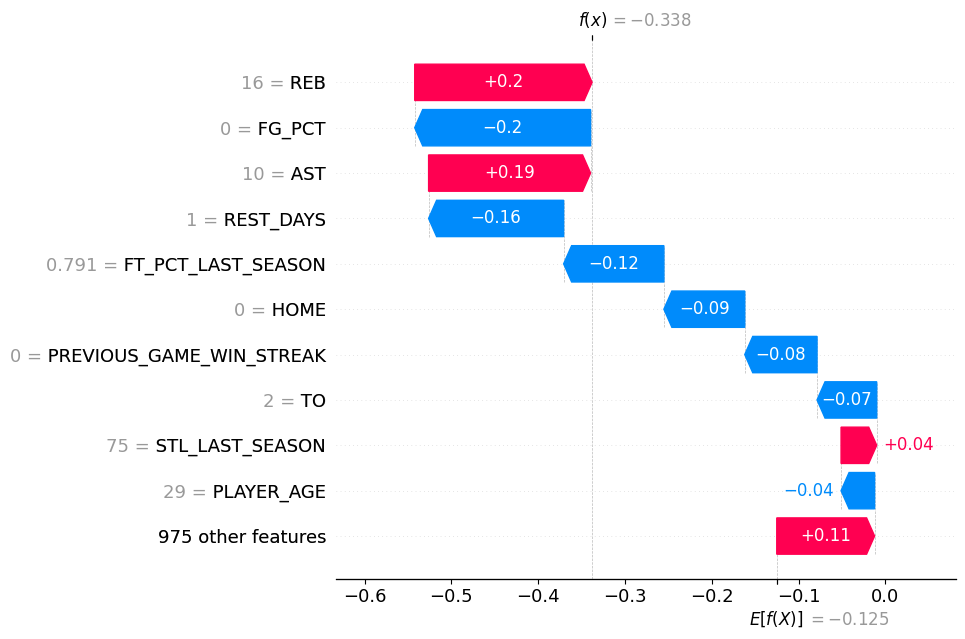

In [70]:
# (4) Train 3 seeds and pick up 1 representative seed result to explain feature to target relationships using shap.
explainer = shap.Explainer(xg_model, X_train)
shap_values = explainer(X_test, check_additivity = False)
# which of the variables are important to the target = bare_nuclei
shap.plots.waterfall(shap_values[0], max_display = 11)

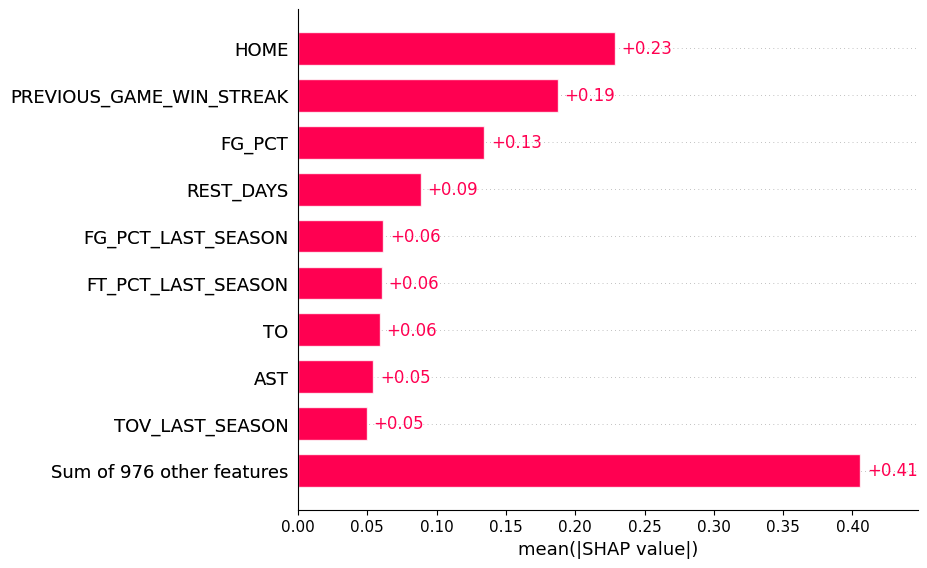

In [71]:
shap.plots.bar(shap_values)

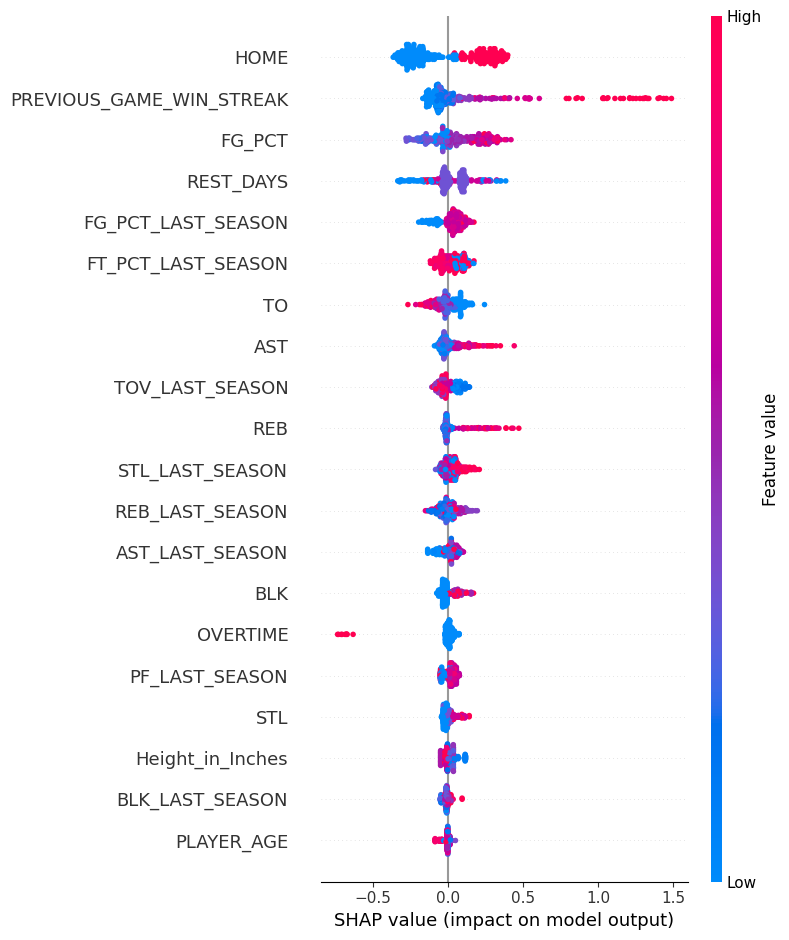

In [72]:
shap.summary_plot(shap_values)

In [84]:
# prompt: use xgboost native api as the model

import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# ... (Your existing code for data loading, preprocessing, and seed generation) ...
seed = random_numbers[1]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Define objective function for Optuna
def objective(trial):
    # Suggest values for hyperparameters
    params = {
        'objective': 'binary:logistic',  # For binary classification
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
        'max_depth': trial.suggest_int("max_depth", 3, 100),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'n_estimators': trial.suggest_int("n_estimators", 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'seed': seed,
    }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    model = xgb.train(params, dtrain)

    y_pred_prob = model.predict(dtest)
    y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create study object
study = optuna.create_study(direction="maximize")

# Run optimization process
study.optimize(objective, n_trials=20, show_progress_bar=True)

# Print best trial and best hyperparameters
print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_params)


# Train the final XGBoost model with the best hyperparameters
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
xg_model = xgb.train(best_params, dtrain)

y_pred_prob = xg_model.predict(dtest)
y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, y_pred, pos_label = 0):.3f}")
print(f"Specificity: {precision_score(y_test, y_pred):.3f}")
print(f"Sensitivity: {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))


[I 2025-02-19 02:32:18,946] A new study created in memory with name: no-name-17d8cfc6-5dc5-4017-a9d2-333f7af218b7


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:32:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:32:23,384] Trial 0 finished with value: 0.6070381231671554 and parameters: {'learning_rate': 0.1824718528390656, 'max_depth': 71, 'subsample': 0.6872132108594081, 'colsample_bytree': 0.5624956215623471, 'n_estimators': 398, 'min_child_weight': 2, 'gamma': 8.120447718273777, 'reg_alpha': 7.912609933424648}. Best is trial 0 with value: 0.6070381231671554.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:32:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:32:26,591] Trial 1 finished with value: 0.5865102639296188 and parameters: {'learning_rate': 0.170516612026044, 'max_depth': 65, 'subsample': 0.9117088885765958, 'colsample_bytree': 0.6312335223058703, 'n_estimators': 164, 'min_child_weight': 5, 'gamma': 5.862205508029755, 'reg_alpha': 9.726859561012997}. Best is trial 0 with value: 0.6070381231671554.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:32:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:32:28,593] Trial 2 finished with value: 0.5395894428152492 and parameters: {'learning_rate': 0.09196050555020696, 'max_depth': 40, 'subsample': 0.9683681611975712, 'colsample_bytree': 0.8409021132715668, 'n_estimators': 201, 'min_child_weight': 2, 'gamma': 2.356159533534133, 'reg_alpha': 5.706016168155098}. Best is trial 0 with value: 0.6070381231671554.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:32:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:32:30,112] Trial 3 finished with value: 0.5483870967741935 and parameters: {'learning_rate': 0.2746348061352034, 'max_depth': 69, 'subsample': 0.563091161116503, 'colsample_bytree': 0.9504173220225259, 'n_estimators': 205, 'min_child_weight': 4, 'gamma': 0.3392894187476403, 'reg_alpha': 3.2288503700116564}. Best is trial 0 with value: 0.6070381231671554.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:32:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:32:31,389] Trial 4 finished with value: 0.5659824046920822 and parameters: {'learning_rate': 0.1953562694329323, 'max_depth': 89, 'subsample': 0.5386208490147231, 'colsample_bytree': 0.5102538090711074, 'n_estimators': 432, 'min_child_weight': 8, 'gamma': 6.730951410763889, 'reg_alpha': 0.0024902623457434547}. Best is trial 0 with value: 0.6070381231671554.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:32:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:32:33,395] Trial 5 finished with value: 0.5571847507331378 and parameters: {'learning_rate': 0.23381111953902975, 'max_depth': 64, 'subsample': 0.9086296528632123, 'colsample_bytree': 0.8088662293230509, 'n_estimators': 101, 'min_child_weight': 8, 'gamma': 0.9821804827543257, 'reg_alpha': 8.752122858286521}. Best is trial 0 with value: 0.6070381231671554.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:32:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:32:37,637] Trial 6 finished with value: 0.533724340175953 and parameters: {'learning_rate': 0.19348185442873922, 'max_depth': 53, 'subsample': 0.9197562314284167, 'colsample_bytree': 0.51566866309285, 'n_estimators': 57, 'min_child_weight': 2, 'gamma': 0.5517743499822125, 'reg_alpha': 4.31439105730383}. Best is trial 0 with value: 0.6070381231671554.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:32:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:32:39,674] Trial 7 finished with value: 0.5894428152492669 and parameters: {'learning_rate': 0.11656272428038135, 'max_depth': 90, 'subsample': 0.8658993130686237, 'colsample_bytree': 0.9136769243901857, 'n_estimators': 389, 'min_child_weight': 10, 'gamma': 8.988588386601965, 'reg_alpha': 6.623546703779865}. Best is trial 0 with value: 0.6070381231671554.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:32:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:32:41,129] Trial 8 finished with value: 0.5073313782991202 and parameters: {'learning_rate': 0.22487341328093857, 'max_depth': 88, 'subsample': 0.9721708589929421, 'colsample_bytree': 0.6557013561705567, 'n_estimators': 288, 'min_child_weight': 7, 'gamma': 0.9014805475542997, 'reg_alpha': 1.5721759042452343}. Best is trial 0 with value: 0.6070381231671554.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:32:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:32:42,704] Trial 9 finished with value: 0.5718475073313783 and parameters: {'learning_rate': 0.24614565254006704, 'max_depth': 49, 'subsample': 0.7037695289431642, 'colsample_bytree': 0.7116456862823097, 'n_estimators': 446, 'min_child_weight': 5, 'gamma': 2.3044162640808272, 'reg_alpha': 1.9239784569049379}. Best is trial 0 with value: 0.6070381231671554.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:32:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:32:45,121] Trial 10 finished with value: 0.5630498533724341 and parameters: {'learning_rate': 0.03369637678287346, 'max_depth': 4, 'subsample': 0.6958330710910724, 'colsample_bytree': 0.6171397836886643, 'n_estimators': 340, 'min_child_weight': 1, 'gamma': 9.935137206051856, 'reg_alpha': 6.910927145728103}. Best is trial 0 with value: 0.6070381231671554.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:32:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:32:47,879] Trial 11 finished with value: 0.5483870967741935 and parameters: {'learning_rate': 0.11133153866805559, 'max_depth': 96, 'subsample': 0.8002153830962506, 'colsample_bytree': 0.9537518814592914, 'n_estimators': 373, 'min_child_weight': 10, 'gamma': 9.046185493167306, 'reg_alpha': 7.117330512253659}. Best is trial 0 with value: 0.6070381231671554.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:32:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:32:51,809] Trial 12 finished with value: 0.5865102639296188 and parameters: {'learning_rate': 0.11507482786988465, 'max_depth': 78, 'subsample': 0.804990961352461, 'colsample_bytree': 0.8552547339286987, 'n_estimators': 381, 'min_child_weight': 10, 'gamma': 7.842482078425432, 'reg_alpha': 7.609880897364166}. Best is trial 0 with value: 0.6070381231671554.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:32:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:32:54,478] Trial 13 finished with value: 0.6217008797653959 and parameters: {'learning_rate': 0.06946916731489566, 'max_depth': 98, 'subsample': 0.6296028548263893, 'colsample_bytree': 0.9930689178542021, 'n_estimators': 480, 'min_child_weight': 3, 'gamma': 7.951710242229639, 'reg_alpha': 5.490761971091073}. Best is trial 13 with value: 0.6217008797653959.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:32:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:32:56,021] Trial 14 finished with value: 0.533724340175953 and parameters: {'learning_rate': 0.03674864226604896, 'max_depth': 24, 'subsample': 0.6200442998118578, 'colsample_bytree': 0.7296598652250444, 'n_estimators': 497, 'min_child_weight': 3, 'gamma': 4.221741183051144, 'reg_alpha': 4.81812104328272}. Best is trial 13 with value: 0.6217008797653959.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:32:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:32:57,290] Trial 15 finished with value: 0.5806451612903226 and parameters: {'learning_rate': 0.07086065044911848, 'max_depth': 99, 'subsample': 0.659342424502869, 'colsample_bytree': 0.5753660625636038, 'n_estimators': 485, 'min_child_weight': 1, 'gamma': 7.226601040633184, 'reg_alpha': 8.66662522794696}. Best is trial 13 with value: 0.6217008797653959.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:32:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:32:58,590] Trial 16 finished with value: 0.5278592375366569 and parameters: {'learning_rate': 0.14216614691466659, 'max_depth': 78, 'subsample': 0.6092195412963323, 'colsample_bytree': 0.7858849532519946, 'n_estimators': 296, 'min_child_weight': 3, 'gamma': 4.884545241998781, 'reg_alpha': 5.751361045403511}. Best is trial 13 with value: 0.6217008797653959.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:32:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:32:59,908] Trial 17 finished with value: 0.5747800586510264 and parameters: {'learning_rate': 0.06926154091760074, 'max_depth': 78, 'subsample': 0.7648334166053825, 'colsample_bytree': 0.9971660128064819, 'n_estimators': 427, 'min_child_weight': 3, 'gamma': 8.238275611684674, 'reg_alpha': 3.561890952756814}. Best is trial 13 with value: 0.6217008797653959.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:33:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:33:01,155] Trial 18 finished with value: 0.5454545454545454 and parameters: {'learning_rate': 0.299008174510172, 'max_depth': 32, 'subsample': 0.5168099807047704, 'colsample_bytree': 0.6884771864937822, 'n_estimators': 329, 'min_child_weight': 6, 'gamma': 5.91275205664965, 'reg_alpha': 8.080158084052986}. Best is trial 13 with value: 0.6217008797653959.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:33:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:33:03,656] Trial 19 finished with value: 0.4809384164222874 and parameters: {'learning_rate': 0.011308528133815526, 'max_depth': 59, 'subsample': 0.7178809559384074, 'colsample_bytree': 0.5823883612646479, 'n_estimators': 464, 'min_child_weight': 4, 'gamma': 3.610848560864982, 'reg_alpha': 9.438527262425797}. Best is trial 13 with value: 0.6217008797653959.
Best trial: FrozenTrial(number=13, state=1, values=[0.6217008797653959], datetime_start=datetime.datetime(2025, 2, 19, 2, 32, 51, 825367), datetime_complete=datetime.datetime(2025, 2, 19, 2, 32, 54, 478140), params={'learning_rate': 0.06946916731489566, 'max_depth': 98, 'subsample': 0.6296028548263893, 'colsample_bytree': 0.9930689178542021, 'n_estimators': 480, 'min_child_weight': 3, 'gamma': 7.951710242229639, 'reg_alpha': 5.490761971091073}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribut

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:33:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.587
F1 Score: 0.667
F1 Score - Negative: 0.456
Specificity: 0.746
Sensitivity: 0.603
ROC AUC: 0.577
[[ 59  48]
 [ 93 141]]


In [85]:
# prompt: use sklearn to selectmodel the base model is xgboost and use it as feature selection and then xgboost native api as machine learning model

from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier  # Import XGBClassifier

# Use the trained GradientBoostingClassifier for feature selection
selector = SelectFromModel(XGBClassifier(**study.best_params), threshold="median")  # Instantiate XGBClassifier with best params
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Train the final XGBoost model with the selected features using native API
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
dtrain = xgb.DMatrix(X_train_selected, label=y_train)
dtest = xgb.DMatrix(X_test_selected, label=y_test)
xg_model_final = xgb.train(best_params, dtrain)

y_pred_prob = xg_model_final.predict(dtest)
y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

print(f"Accuracy (with feature selection): {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score (with feature selection): {f1_score(y_test, y_pred):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, y_pred, pos_label = 0):.3f}")
print(f"Specificity (with feature selection): {precision_score(y_test, y_pred):.3f}")
print(f"Sensitivity (with feature selection): {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC (with feature selection): {roc_auc_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:33:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (with feature selection): 0.587
F1 Score (with feature selection): 0.667
F1 Score - Negative: 0.456
Specificity (with feature selection): 0.746
Sensitivity (with feature selection): 0.603
ROC AUC (with feature selection): 0.577
[[ 59  48]
 [ 93 141]]


In [86]:
explainer = shap.Explainer(xg_model, X_train)
shap_values2 = explainer(X_test, check_additivity = False)

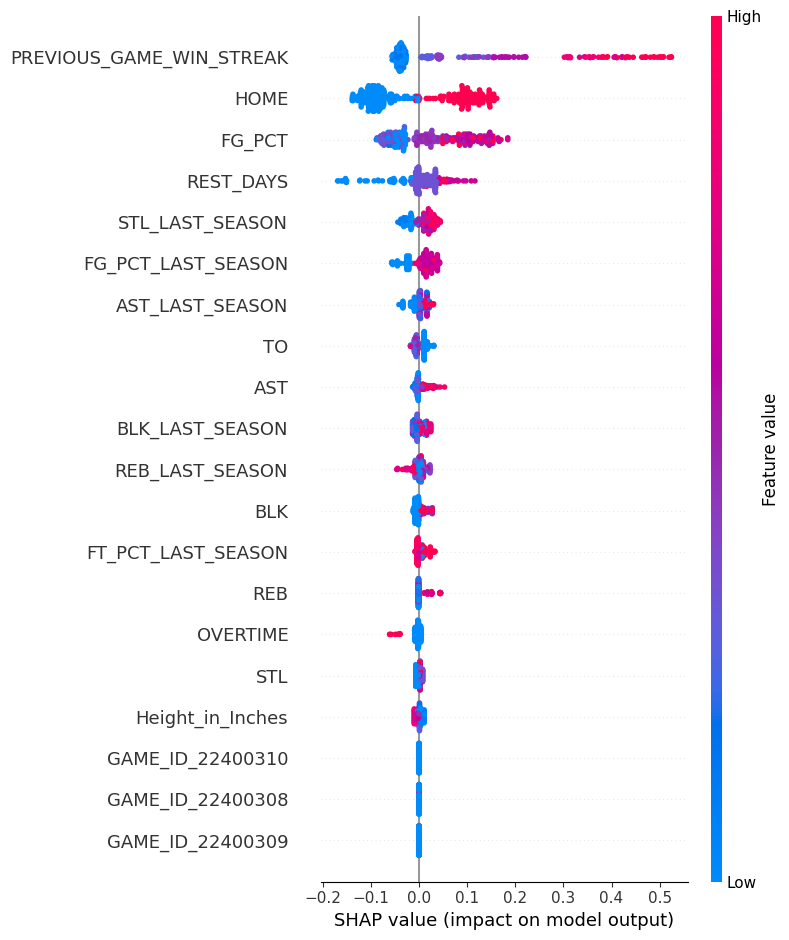

In [87]:
shap.summary_plot(shap_values2)

In [88]:
# # prompt: use xgboost native api as the model

import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# ... (Your existing code for data loading, preprocessing, and seed generation) ...
seed = random_numbers[2]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Define objective function for Optuna
def objective(trial):
    # Suggest values for hyperparameters
    params = {
        'objective': 'binary:logistic',  # For binary classification
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
        'max_depth': trial.suggest_int("max_depth", 3, 100),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'n_estimators': trial.suggest_int("n_estimators", 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'seed': seed,
    }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    model = xgb.train(params, dtrain)

    y_pred_prob = model.predict(dtest)
    y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create study object
study = optuna.create_study(direction="maximize")

# Run optimization process
study.optimize(objective, n_trials=20, show_progress_bar=True)

# Print best trial and best hyperparameters
print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_params)


# Train the final XGBoost model with the best hyperparameters
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
xg_model = xgb.train(best_params, dtrain)

y_pred_prob = xg_model.predict(dtest)
y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, y_pred, pos_label = 0):.3f}")
print(f"Specificity: {precision_score(y_test, y_pred):.3f}")
print(f"Sensitivity: {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))


[I 2025-02-19 02:33:49,665] A new study created in memory with name: no-name-063db972-c9d0-436a-8c31-14333126989c


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:33:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:33:51,452] Trial 0 finished with value: 0.5659824046920822 and parameters: {'learning_rate': 0.19859647484378862, 'max_depth': 97, 'subsample': 0.705229349656517, 'colsample_bytree': 0.6110708865423369, 'n_estimators': 438, 'min_child_weight': 10, 'gamma': 7.510683399221531, 'reg_alpha': 4.366663760299712}. Best is trial 0 with value: 0.5659824046920822.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:33:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:33:53,688] Trial 1 finished with value: 0.5454545454545454 and parameters: {'learning_rate': 0.2867125870705958, 'max_depth': 35, 'subsample': 0.8521717447261761, 'colsample_bytree': 0.8373423645656255, 'n_estimators': 91, 'min_child_weight': 2, 'gamma': 8.179934442137725, 'reg_alpha': 1.7216629137809547}. Best is trial 0 with value: 0.5659824046920822.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:33:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:33:54,946] Trial 2 finished with value: 0.5513196480938416 and parameters: {'learning_rate': 0.2929479393632645, 'max_depth': 47, 'subsample': 0.5098302108087955, 'colsample_bytree': 0.8514085381807034, 'n_estimators': 478, 'min_child_weight': 1, 'gamma': 5.547322604106791, 'reg_alpha': 1.3932484906801756}. Best is trial 0 with value: 0.5659824046920822.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:33:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:33:56,160] Trial 3 finished with value: 0.6011730205278593 and parameters: {'learning_rate': 0.18187152811457438, 'max_depth': 52, 'subsample': 0.8100299226326055, 'colsample_bytree': 0.7507794050770547, 'n_estimators': 357, 'min_child_weight': 2, 'gamma': 7.172882281907711, 'reg_alpha': 9.866501539391157}. Best is trial 3 with value: 0.6011730205278593.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:33:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:33:57,593] Trial 4 finished with value: 0.5278592375366569 and parameters: {'learning_rate': 0.08129526798212834, 'max_depth': 52, 'subsample': 0.9340976463755785, 'colsample_bytree': 0.5488124320751171, 'n_estimators': 102, 'min_child_weight': 9, 'gamma': 1.3787496063748306, 'reg_alpha': 2.425949854369396}. Best is trial 3 with value: 0.6011730205278593.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:33:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:33:58,798] Trial 5 finished with value: 0.5777126099706745 and parameters: {'learning_rate': 0.28152198905228765, 'max_depth': 20, 'subsample': 0.6749409452148598, 'colsample_bytree': 0.8598628428477264, 'n_estimators': 418, 'min_child_weight': 6, 'gamma': 7.600626386843182, 'reg_alpha': 7.028669233862833}. Best is trial 3 with value: 0.6011730205278593.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:33:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:34:00,053] Trial 6 finished with value: 0.49560117302052786 and parameters: {'learning_rate': 0.016317618346733783, 'max_depth': 27, 'subsample': 0.7479403814598082, 'colsample_bytree': 0.691871565886824, 'n_estimators': 467, 'min_child_weight': 4, 'gamma': 6.523290016261749, 'reg_alpha': 9.398857949227356}. Best is trial 3 with value: 0.6011730205278593.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:34:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:34:01,396] Trial 7 finished with value: 0.5483870967741935 and parameters: {'learning_rate': 0.18163843955409542, 'max_depth': 27, 'subsample': 0.9427131476652558, 'colsample_bytree': 0.9433171475807061, 'n_estimators': 283, 'min_child_weight': 5, 'gamma': 2.2703495299655287, 'reg_alpha': 9.577944772750236}. Best is trial 3 with value: 0.6011730205278593.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:34:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:34:02,701] Trial 8 finished with value: 0.5689149560117303 and parameters: {'learning_rate': 0.2192789877571222, 'max_depth': 9, 'subsample': 0.6382190956662843, 'colsample_bytree': 0.6984260800333213, 'n_estimators': 124, 'min_child_weight': 10, 'gamma': 2.8267689174444035, 'reg_alpha': 9.42381539031006}. Best is trial 3 with value: 0.6011730205278593.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:34:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:34:04,253] Trial 9 finished with value: 0.5601173020527859 and parameters: {'learning_rate': 0.08676198649378415, 'max_depth': 6, 'subsample': 0.6574105828933847, 'colsample_bytree': 0.8812243456278558, 'n_estimators': 244, 'min_child_weight': 1, 'gamma': 2.5011780890855717, 'reg_alpha': 4.130918520284972}. Best is trial 3 with value: 0.6011730205278593.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:34:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:34:06,355] Trial 10 finished with value: 0.5865102639296188 and parameters: {'learning_rate': 0.12596293257834387, 'max_depth': 74, 'subsample': 0.8409932893926009, 'colsample_bytree': 0.7501051643216874, 'n_estimators': 354, 'min_child_weight': 3, 'gamma': 9.945825132464549, 'reg_alpha': 6.44007280512257}. Best is trial 3 with value: 0.6011730205278593.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:34:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:34:07,763] Trial 11 finished with value: 0.5835777126099707 and parameters: {'learning_rate': 0.13937112618412734, 'max_depth': 74, 'subsample': 0.8307457998433919, 'colsample_bytree': 0.7529846254640824, 'n_estimators': 341, 'min_child_weight': 3, 'gamma': 9.913513475715286, 'reg_alpha': 6.828408266025297}. Best is trial 3 with value: 0.6011730205278593.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:34:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:34:09,029] Trial 12 finished with value: 0.6187683284457478 and parameters: {'learning_rate': 0.13106494185965645, 'max_depth': 70, 'subsample': 0.8450758479581445, 'colsample_bytree': 0.7641038033306324, 'n_estimators': 352, 'min_child_weight': 7, 'gamma': 9.988448254312479, 'reg_alpha': 7.187810630231857}. Best is trial 12 with value: 0.6187683284457478.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:34:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:34:10,292] Trial 13 finished with value: 0.5630498533724341 and parameters: {'learning_rate': 0.10037777030155418, 'max_depth': 67, 'subsample': 0.7995026997262686, 'colsample_bytree': 0.6448736832712822, 'n_estimators': 223, 'min_child_weight': 7, 'gamma': 4.851671062612988, 'reg_alpha': 8.07554743236747}. Best is trial 12 with value: 0.6187683284457478.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:34:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:34:11,587] Trial 14 finished with value: 0.5806451612903226 and parameters: {'learning_rate': 0.22076871969804768, 'max_depth': 96, 'subsample': 0.904720134386689, 'colsample_bytree': 0.790049236739494, 'n_estimators': 361, 'min_child_weight': 8, 'gamma': 8.825634824363338, 'reg_alpha': 7.727923359913909}. Best is trial 12 with value: 0.6187683284457478.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:34:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:34:12,938] Trial 15 finished with value: 0.5425219941348973 and parameters: {'learning_rate': 0.1638308130711753, 'max_depth': 59, 'subsample': 0.997163056413869, 'colsample_bytree': 0.9637784534444314, 'n_estimators': 296, 'min_child_weight': 6, 'gamma': 4.472048949096968, 'reg_alpha': 5.602855580433276}. Best is trial 12 with value: 0.6187683284457478.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:34:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:34:14,228] Trial 16 finished with value: 0.5718475073313783 and parameters: {'learning_rate': 0.24172151191263094, 'max_depth': 81, 'subsample': 0.7579353555753109, 'colsample_bytree': 0.509559072381438, 'n_estimators': 184, 'min_child_weight': 7, 'gamma': 6.1773725800030075, 'reg_alpha': 8.448485078074887}. Best is trial 12 with value: 0.6187683284457478.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:34:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:34:16,002] Trial 17 finished with value: 0.5630498533724341 and parameters: {'learning_rate': 0.05146724730553845, 'max_depth': 45, 'subsample': 0.551164646709837, 'colsample_bytree': 0.7955578630978799, 'n_estimators': 390, 'min_child_weight': 5, 'gamma': 8.848915419468778, 'reg_alpha': 0.22914262799476148}. Best is trial 12 with value: 0.6187683284457478.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:34:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:34:18,474] Trial 18 finished with value: 0.5542521994134897 and parameters: {'learning_rate': 0.12589476161754268, 'max_depth': 86, 'subsample': 0.885338484437853, 'colsample_bytree': 0.6836813307365528, 'n_estimators': 304, 'min_child_weight': 4, 'gamma': 3.8108113624157705, 'reg_alpha': 5.168280072151998}. Best is trial 12 with value: 0.6187683284457478.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:34:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:34:20,343] Trial 19 finished with value: 0.530791788856305 and parameters: {'learning_rate': 0.1529361347222913, 'max_depth': 59, 'subsample': 0.7706272424689378, 'colsample_bytree': 0.9101456492055318, 'n_estimators': 197, 'min_child_weight': 8, 'gamma': 0.02871760399051837, 'reg_alpha': 8.658250801584106}. Best is trial 12 with value: 0.6187683284457478.
Best trial: FrozenTrial(number=12, state=1, values=[0.6187683284457478], datetime_start=datetime.datetime(2025, 2, 19, 2, 34, 7, 773048), datetime_complete=datetime.datetime(2025, 2, 19, 2, 34, 9, 29372), params={'learning_rate': 0.13106494185965645, 'max_depth': 70, 'subsample': 0.8450758479581445, 'colsample_bytree': 0.7641038033306324, 'n_estimators': 352, 'min_child_weight': 7, 'gamma': 9.988448254312479, 'reg_alpha': 7.187810630231857}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:34:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.543
F1 Score: 0.642
F1 Score - Negative: 0.366
Specificity: 0.693
Sensitivity: 0.598
ROC AUC: 0.509
[[ 45  62]
 [ 94 140]]


In [89]:
# prompt: use sklearn to selectmodel the base model is xgboost and use it as feature selection and then xgboost native api as machine learning model

from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier  # Import XGBClassifier

# Use the trained GradientBoostingClassifier for feature selection
selector = SelectFromModel(XGBClassifier(**study.best_params), threshold="median")  # Instantiate XGBClassifier with best params
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Train the final XGBoost model with the selected features using native API
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
dtrain = xgb.DMatrix(X_train_selected, label=y_train)
dtest = xgb.DMatrix(X_test_selected, label=y_test)
xg_model_final = xgb.train(best_params, dtrain)

y_pred_prob = xg_model_final.predict(dtest)
y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

print(f"Accuracy (with feature selection): {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score (with feature selection): {f1_score(y_test, y_pred):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, y_pred, pos_label = 0):.3f}")
print(f"Specificity (with feature selection): {precision_score(y_test, y_pred):.3f}")
print(f"Sensitivity (with feature selection): {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC (with feature selection): {roc_auc_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:35:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (with feature selection): 0.543
F1 Score (with feature selection): 0.642
F1 Score - Negative: 0.366
Specificity (with feature selection): 0.693
Sensitivity (with feature selection): 0.598
ROC AUC (with feature selection): 0.509
[[ 45  62]
 [ 94 140]]


In [90]:
explainer = shap.Explainer(xg_model, X_train)
shap_values3 = explainer(X_test, check_additivity = False)

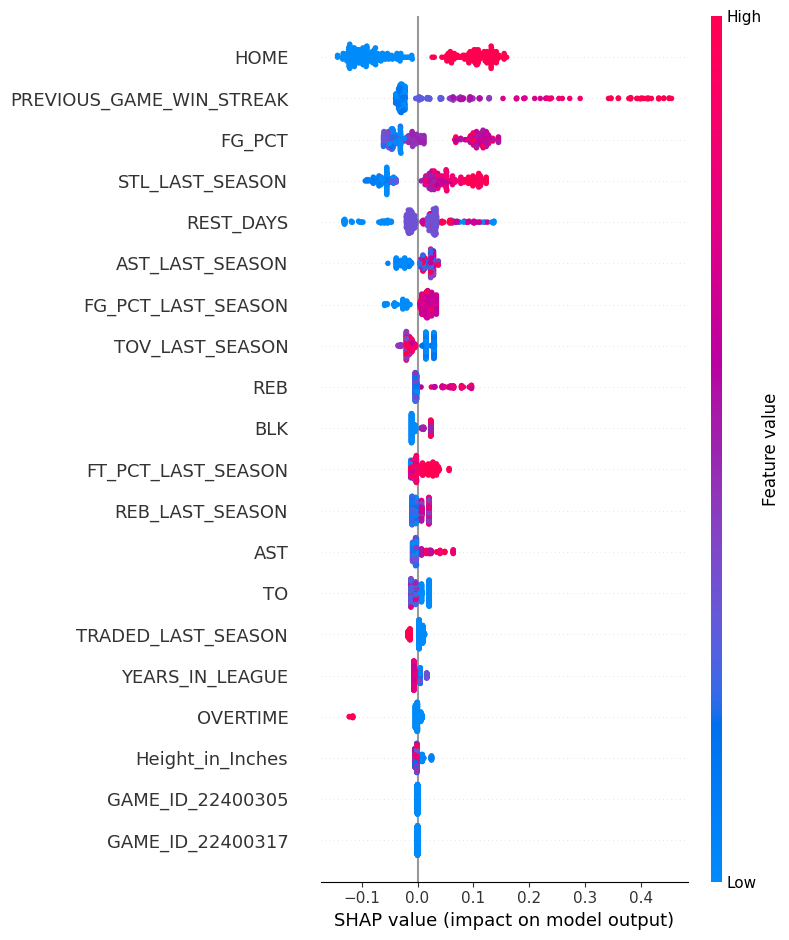

In [91]:
shap.summary_plot(shap_values3)

In [96]:
# prompt: use xgboost native api as the model

import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# ... (Your existing code for data loading, preprocessing, and seed generation) ...
seed = random_numbers[3]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Define objective function for Optuna
def objective(trial):
    # Suggest values for hyperparameters
    params = {
        'objective': 'binary:logistic',  # For binary classification
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
        'max_depth': trial.suggest_int("max_depth", 3, 100),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'n_estimators': trial.suggest_int("n_estimators", 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'seed': seed,
    }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    model = xgb.train(params, dtrain)

    y_pred_prob = model.predict(dtest)
    y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create study object
study = optuna.create_study(direction="maximize")

# Run optimization process
study.optimize(objective, n_trials=20, show_progress_bar=True)

# Print best trial and best hyperparameters
print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_params)


# Train the final XGBoost model with the best hyperparameters
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
xg_model = xgb.train(best_params, dtrain)

y_pred_prob = xg_model.predict(dtest)
y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, y_pred, pos_label = 0):.3f}")
print(f"Specificity: {precision_score(y_test, y_pred):.3f}")
print(f"Sensitivity: {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))

[I 2025-02-19 02:36:16,474] A new study created in memory with name: no-name-01f53877-2a43-4b00-abc9-c20509c39290


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:36:21,271] Trial 0 finished with value: 0.5454545454545454 and parameters: {'learning_rate': 0.2742240176349649, 'max_depth': 61, 'subsample': 0.8079660510640864, 'colsample_bytree': 0.5591972997269841, 'n_estimators': 180, 'min_child_weight': 1, 'gamma': 3.3751324384614145, 'reg_alpha': 2.954552322670664}. Best is trial 0 with value: 0.5454545454545454.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:36:24,129] Trial 1 finished with value: 0.5718475073313783 and parameters: {'learning_rate': 0.07955108093727456, 'max_depth': 15, 'subsample': 0.5485971766176276, 'colsample_bytree': 0.5410607827925276, 'n_estimators': 91, 'min_child_weight': 9, 'gamma': 6.118994408745838, 'reg_alpha': 5.237274041753283}. Best is trial 1 with value: 0.5718475073313783.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:36:26,106] Trial 2 finished with value: 0.5073313782991202 and parameters: {'learning_rate': 0.07374282051196415, 'max_depth': 93, 'subsample': 0.6881477278976934, 'colsample_bytree': 0.7719290786008637, 'n_estimators': 188, 'min_child_weight': 9, 'gamma': 3.201109877656272, 'reg_alpha': 0.38904376862176293}. Best is trial 1 with value: 0.5718475073313783.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:36:27,313] Trial 3 finished with value: 0.6041055718475073 and parameters: {'learning_rate': 0.25926751419923566, 'max_depth': 90, 'subsample': 0.5429839778001946, 'colsample_bytree': 0.9101112381738521, 'n_estimators': 377, 'min_child_weight': 5, 'gamma': 4.802988906842284, 'reg_alpha': 9.961503674251889}. Best is trial 3 with value: 0.6041055718475073.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:36:28,539] Trial 4 finished with value: 0.5395894428152492 and parameters: {'learning_rate': 0.02643487717135623, 'max_depth': 68, 'subsample': 0.6832417585101124, 'colsample_bytree': 0.5173199876931418, 'n_estimators': 338, 'min_child_weight': 8, 'gamma': 6.638678571628436, 'reg_alpha': 1.513988867440732}. Best is trial 3 with value: 0.6041055718475073.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:36:29,833] Trial 5 finished with value: 0.5601173020527859 and parameters: {'learning_rate': 0.2229663011921594, 'max_depth': 47, 'subsample': 0.9410176320226833, 'colsample_bytree': 0.8050565346281421, 'n_estimators': 243, 'min_child_weight': 2, 'gamma': 3.7326883159602344, 'reg_alpha': 6.161903796509768}. Best is trial 3 with value: 0.6041055718475073.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:36:32,278] Trial 6 finished with value: 0.5718475073313783 and parameters: {'learning_rate': 0.2782809634636318, 'max_depth': 51, 'subsample': 0.6033256197379679, 'colsample_bytree': 0.6490713743353552, 'n_estimators': 56, 'min_child_weight': 10, 'gamma': 3.324407863809964, 'reg_alpha': 1.5803270673959036}. Best is trial 3 with value: 0.6041055718475073.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:36:33,815] Trial 7 finished with value: 0.5395894428152492 and parameters: {'learning_rate': 0.0342410970294001, 'max_depth': 58, 'subsample': 0.9929964898757118, 'colsample_bytree': 0.6670369233789397, 'n_estimators': 479, 'min_child_weight': 10, 'gamma': 2.3286923282569614, 'reg_alpha': 5.994651430661487}. Best is trial 3 with value: 0.6041055718475073.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:36:35,033] Trial 8 finished with value: 0.5454545454545454 and parameters: {'learning_rate': 0.019512995141612602, 'max_depth': 26, 'subsample': 0.5431988384117412, 'colsample_bytree': 0.6782418815133012, 'n_estimators': 450, 'min_child_weight': 6, 'gamma': 9.55884057335814, 'reg_alpha': 7.677538119304604}. Best is trial 3 with value: 0.6041055718475073.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:36:36,276] Trial 9 finished with value: 0.5747800586510264 and parameters: {'learning_rate': 0.1717731067559425, 'max_depth': 38, 'subsample': 0.6578800300363574, 'colsample_bytree': 0.8559795089105554, 'n_estimators': 89, 'min_child_weight': 5, 'gamma': 5.497501630402779, 'reg_alpha': 5.138629130454584}. Best is trial 3 with value: 0.6041055718475073.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:36:37,720] Trial 10 finished with value: 0.5571847507331378 and parameters: {'learning_rate': 0.1767320181194546, 'max_depth': 98, 'subsample': 0.8175614706214556, 'colsample_bytree': 0.991848605501394, 'n_estimators': 369, 'min_child_weight': 4, 'gamma': 0.6040863486075176, 'reg_alpha': 9.570726247163694}. Best is trial 3 with value: 0.6041055718475073.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:36:38,985] Trial 11 finished with value: 0.5982404692082112 and parameters: {'learning_rate': 0.15996125237432207, 'max_depth': 29, 'subsample': 0.6359462168323633, 'colsample_bytree': 0.9163727467917387, 'n_estimators': 366, 'min_child_weight': 6, 'gamma': 7.691502216813701, 'reg_alpha': 9.858152465759016}. Best is trial 3 with value: 0.6041055718475073.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:36:40,229] Trial 12 finished with value: 0.624633431085044 and parameters: {'learning_rate': 0.22255804273224394, 'max_depth': 79, 'subsample': 0.5210120049626411, 'colsample_bytree': 0.9466867058755484, 'n_estimators': 377, 'min_child_weight': 7, 'gamma': 7.840359719112979, 'reg_alpha': 9.813600049891843}. Best is trial 12 with value: 0.624633431085044.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:36:41,510] Trial 13 finished with value: 0.5894428152492669 and parameters: {'learning_rate': 0.22854437538232042, 'max_depth': 79, 'subsample': 0.5183882705603133, 'colsample_bytree': 0.9946207195887017, 'n_estimators': 298, 'min_child_weight': 7, 'gamma': 8.548412982845434, 'reg_alpha': 8.097290304134097}. Best is trial 12 with value: 0.624633431085044.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:36:42,737] Trial 14 finished with value: 0.6099706744868035 and parameters: {'learning_rate': 0.2279512949925791, 'max_depth': 82, 'subsample': 0.5011877654663004, 'colsample_bytree': 0.9068653523867722, 'n_estimators': 419, 'min_child_weight': 4, 'gamma': 7.612849650601847, 'reg_alpha': 8.161553225065713}. Best is trial 12 with value: 0.624633431085044.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:36:44,972] Trial 15 finished with value: 0.5718475073313783 and parameters: {'learning_rate': 0.20695535060644657, 'max_depth': 77, 'subsample': 0.7666877623383975, 'colsample_bytree': 0.8949673330565577, 'n_estimators': 426, 'min_child_weight': 3, 'gamma': 7.647789658863593, 'reg_alpha': 7.904701453501911}. Best is trial 12 with value: 0.624633431085044.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:36:46,429] Trial 16 finished with value: 0.6363636363636364 and parameters: {'learning_rate': 0.12506528811051595, 'max_depth': 80, 'subsample': 0.5029441129045215, 'colsample_bytree': 0.8300130042647378, 'n_estimators': 433, 'min_child_weight': 4, 'gamma': 9.840280015044545, 'reg_alpha': 8.57764162390251}. Best is trial 16 with value: 0.6363636363636364.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:36:47,691] Trial 17 finished with value: 0.6129032258064516 and parameters: {'learning_rate': 0.11418197808469674, 'max_depth': 70, 'subsample': 0.5972038307806197, 'colsample_bytree': 0.8349877055274011, 'n_estimators': 310, 'min_child_weight': 7, 'gamma': 9.918452611724547, 'reg_alpha': 6.814307556687644}. Best is trial 16 with value: 0.6363636363636364.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:36:49,034] Trial 18 finished with value: 0.5894428152492669 and parameters: {'learning_rate': 0.12945932976041807, 'max_depth': 100, 'subsample': 0.8888841025231036, 'colsample_bytree': 0.9640001976275201, 'n_estimators': 500, 'min_child_weight': 3, 'gamma': 8.957730413461858, 'reg_alpha': 3.5714073379983358}. Best is trial 16 with value: 0.6363636363636364.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:36:50,302] Trial 19 finished with value: 0.530791788856305 and parameters: {'learning_rate': 0.1261472048825155, 'max_depth': 84, 'subsample': 0.7231077800969551, 'colsample_bytree': 0.7502531386189257, 'n_estimators': 256, 'min_child_weight': 7, 'gamma': 8.333986046353752, 'reg_alpha': 8.938771357173481}. Best is trial 16 with value: 0.6363636363636364.
Best trial: FrozenTrial(number=16, state=1, values=[0.6363636363636364], datetime_start=datetime.datetime(2025, 2, 19, 2, 36, 44, 984221), datetime_complete=datetime.datetime(2025, 2, 19, 2, 36, 46, 429007), params={'learning_rate': 0.12506528811051595, 'max_depth': 80, 'subsample': 0.5029441129045215, 'colsample_bytree': 0.8300130042647378, 'n_estimators': 433, 'min_child_weight': 4, 'gamma': 9.840280015044545, 'reg_alpha': 8.57764162390251}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.572
F1 Score: 0.665
F1 Score - Negative: 0.407
Specificity: 0.718
Sensitivity: 0.620
ROC AUC: 0.543
[[ 50  57]
 [ 89 145]]


In [97]:
# prompt: use sklearn to selectmodel the base model is xgboost and use it as feature selection and then xgboost native api as machine learning model

from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier  # Import XGBClassifier

# Use the trained GradientBoostingClassifier for feature selection
selector = SelectFromModel(XGBClassifier(**study.best_params), threshold="median")  # Instantiate XGBClassifier with best params
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Train the final XGBoost model with the selected features using native API
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
dtrain = xgb.DMatrix(X_train_selected, label=y_train)
dtest = xgb.DMatrix(X_test_selected, label=y_test)
xg_model_final = xgb.train(best_params, dtrain)

y_pred_prob = xg_model_final.predict(dtest)
y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

print(f"Accuracy (with feature selection): {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score (with feature selection): {f1_score(y_test, y_pred):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, y_pred, pos_label = 0):.3f}")
print(f"Specificity (with feature selection): {precision_score(y_test, y_pred):.3f}")
print(f"Sensitivity (with feature selection): {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC (with feature selection): {roc_auc_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:37:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (with feature selection): 0.572
F1 Score (with feature selection): 0.665
F1 Score - Negative: 0.407
Specificity (with feature selection): 0.718
Sensitivity (with feature selection): 0.620
ROC AUC (with feature selection): 0.543
[[ 50  57]
 [ 89 145]]


In [98]:
explainer = shap.Explainer(xg_model, X_train)
shap_values4 = explainer(X_test, check_additivity = False)

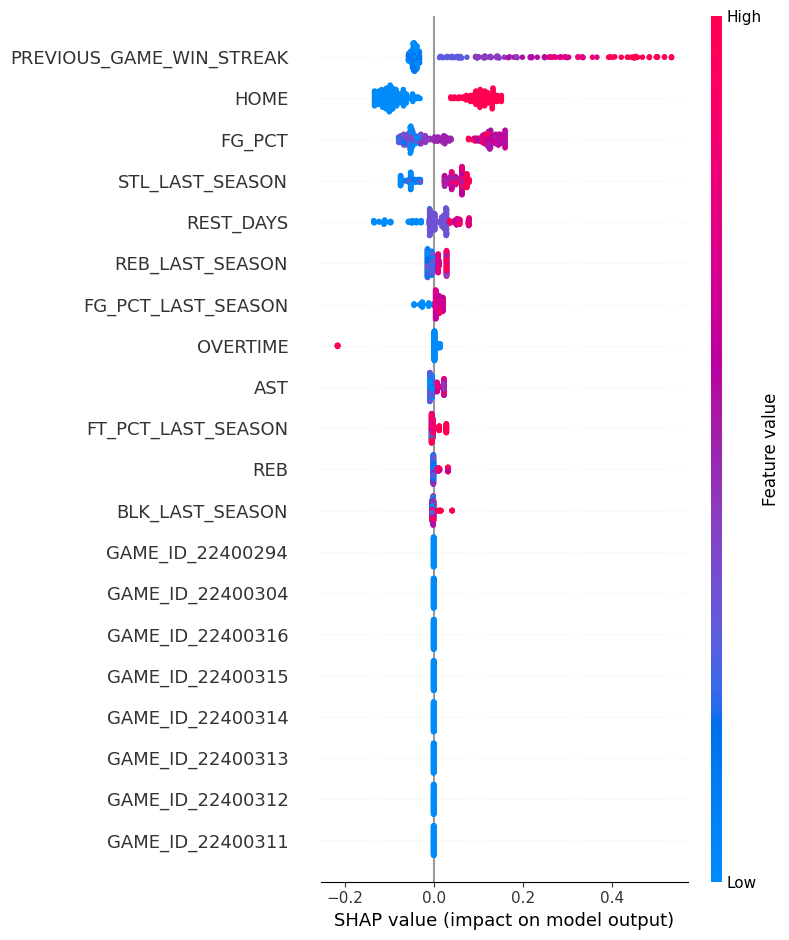

In [99]:
shap.summary_plot(shap_values4)

In [100]:
# prompt: use xgboost native api as the model

import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# ... (Your existing code for data loading, preprocessing, and seed generation) ...
seed = random_numbers[4]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Define objective function for Optuna
def objective(trial):
    # Suggest values for hyperparameters
    params = {
        'objective': 'binary:logistic',  # For binary classification
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
        'max_depth': trial.suggest_int("max_depth", 3, 100),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'n_estimators': trial.suggest_int("n_estimators", 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'seed': seed,
    }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    model = xgb.train(params, dtrain)

    y_pred_prob = model.predict(dtest)
    y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create study object
study = optuna.create_study(direction="maximize")

# Run optimization process
study.optimize(objective, n_trials=20, show_progress_bar=True)

# Print best trial and best hyperparameters
print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_params)


# Train the final XGBoost model with the best hyperparameters
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
xg_model = xgb.train(best_params, dtrain)

y_pred_prob = xg_model.predict(dtest)
y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, y_pred, pos_label = 0):.3f}")
print(f"Specificity: {precision_score(y_test, y_pred):.3f}")
print(f"Sensitivity: {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))

[I 2025-02-19 02:37:29,390] A new study created in memory with name: no-name-0573438a-d8ba-4a21-8a81-77722e5417c5


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:37:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:37:35,447] Trial 0 finished with value: 0.5571847507331378 and parameters: {'learning_rate': 0.10921422658690652, 'max_depth': 19, 'subsample': 0.8246996650200218, 'colsample_bytree': 0.7162565225895048, 'n_estimators': 344, 'min_child_weight': 4, 'gamma': 0.3772866836079203, 'reg_alpha': 5.247474486483989}. Best is trial 0 with value: 0.5571847507331378.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:37:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:37:38,934] Trial 1 finished with value: 0.530791788856305 and parameters: {'learning_rate': 0.15571290910044785, 'max_depth': 25, 'subsample': 0.9386204060352299, 'colsample_bytree': 0.6248864267353715, 'n_estimators': 84, 'min_child_weight': 1, 'gamma': 0.22755518651881856, 'reg_alpha': 2.1371946340870496}. Best is trial 0 with value: 0.5571847507331378.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:37:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:37:40,181] Trial 2 finished with value: 0.5513196480938416 and parameters: {'learning_rate': 0.05661116672611049, 'max_depth': 89, 'subsample': 0.67901715081155, 'colsample_bytree': 0.6593362608130362, 'n_estimators': 452, 'min_child_weight': 9, 'gamma': 9.171760507317664, 'reg_alpha': 9.609476554124605}. Best is trial 0 with value: 0.5571847507331378.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:37:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:37:41,864] Trial 3 finished with value: 0.5249266862170088 and parameters: {'learning_rate': 0.1183091569642712, 'max_depth': 63, 'subsample': 0.8356552120212141, 'colsample_bytree': 0.9272278340782364, 'n_estimators': 318, 'min_child_weight': 3, 'gamma': 0.5780438268066057, 'reg_alpha': 1.317521036308139}. Best is trial 0 with value: 0.5571847507331378.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:37:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:37:43,068] Trial 4 finished with value: 0.5806451612903226 and parameters: {'learning_rate': 0.2533037198612073, 'max_depth': 33, 'subsample': 0.8733393886079373, 'colsample_bytree': 0.7284075669031815, 'n_estimators': 455, 'min_child_weight': 10, 'gamma': 9.80887932832128, 'reg_alpha': 0.5187964332891248}. Best is trial 4 with value: 0.5806451612903226.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:37:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:37:44,348] Trial 5 finished with value: 0.5835777126099707 and parameters: {'learning_rate': 0.12245833661914768, 'max_depth': 73, 'subsample': 0.6208732277042145, 'colsample_bytree': 0.9197386692692003, 'n_estimators': 427, 'min_child_weight': 7, 'gamma': 7.0859781236560595, 'reg_alpha': 9.9532975170891}. Best is trial 5 with value: 0.5835777126099707.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:37:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:37:46,761] Trial 6 finished with value: 0.5835777126099707 and parameters: {'learning_rate': 0.10630729950545352, 'max_depth': 11, 'subsample': 0.7857440269194977, 'colsample_bytree': 0.9263748500863943, 'n_estimators': 340, 'min_child_weight': 10, 'gamma': 5.682203926168359, 'reg_alpha': 6.39978750418927}. Best is trial 5 with value: 0.5835777126099707.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:37:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:37:48,263] Trial 7 finished with value: 0.5571847507331378 and parameters: {'learning_rate': 0.2528222388927988, 'max_depth': 96, 'subsample': 0.6576180256717379, 'colsample_bytree': 0.5227438053672182, 'n_estimators': 435, 'min_child_weight': 6, 'gamma': 5.2305365441833, 'reg_alpha': 3.285081076275247}. Best is trial 5 with value: 0.5835777126099707.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:37:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:37:49,686] Trial 8 finished with value: 0.5425219941348973 and parameters: {'learning_rate': 0.28262775228667336, 'max_depth': 51, 'subsample': 0.5955311601625154, 'colsample_bytree': 0.7712844975963591, 'n_estimators': 304, 'min_child_weight': 1, 'gamma': 0.681866542394558, 'reg_alpha': 8.592664268387578}. Best is trial 5 with value: 0.5835777126099707.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:37:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:37:50,925] Trial 9 finished with value: 0.5425219941348973 and parameters: {'learning_rate': 0.2927408782577602, 'max_depth': 56, 'subsample': 0.9499628879805719, 'colsample_bytree': 0.847532411190086, 'n_estimators': 491, 'min_child_weight': 7, 'gamma': 7.628741297569124, 'reg_alpha': 1.586225167126658}. Best is trial 5 with value: 0.5835777126099707.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:37:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:37:52,203] Trial 10 finished with value: 0.5278592375366569 and parameters: {'learning_rate': 0.015394912679141295, 'max_depth': 74, 'subsample': 0.5726884941848721, 'colsample_bytree': 0.9879109469138116, 'n_estimators': 181, 'min_child_weight': 8, 'gamma': 3.3895788645946174, 'reg_alpha': 7.575300355059339}. Best is trial 5 with value: 0.5835777126099707.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:37:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:37:53,515] Trial 11 finished with value: 0.5601173020527859 and parameters: {'learning_rate': 0.17892262756506835, 'max_depth': 8, 'subsample': 0.7110946071763841, 'colsample_bytree': 0.8763395954247275, 'n_estimators': 378, 'min_child_weight': 10, 'gamma': 6.166071276457556, 'reg_alpha': 6.223052242877229}. Best is trial 5 with value: 0.5835777126099707.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:37:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:37:54,825] Trial 12 finished with value: 0.5806451612903226 and parameters: {'learning_rate': 0.09755252683110978, 'max_depth': 79, 'subsample': 0.5053074020823513, 'colsample_bytree': 0.9913385201653058, 'n_estimators': 223, 'min_child_weight': 8, 'gamma': 3.7597603902398684, 'reg_alpha': 6.7096939296638105}. Best is trial 5 with value: 0.5835777126099707.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:37:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:37:56,117] Trial 13 finished with value: 0.5777126099706745 and parameters: {'learning_rate': 0.19233681345552495, 'max_depth': 41, 'subsample': 0.7737650009230899, 'colsample_bytree': 0.8382001613406928, 'n_estimators': 387, 'min_child_weight': 5, 'gamma': 6.8111580025193, 'reg_alpha': 9.853719448674568}. Best is trial 5 with value: 0.5835777126099707.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:37:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:37:57,332] Trial 14 finished with value: 0.5777126099706745 and parameters: {'learning_rate': 0.060605968309913244, 'max_depth': 4, 'subsample': 0.7517783424949027, 'colsample_bytree': 0.9195477346408923, 'n_estimators': 240, 'min_child_weight': 7, 'gamma': 8.482844175104109, 'reg_alpha': 3.985158325557184}. Best is trial 5 with value: 0.5835777126099707.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:37:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:37:59,746] Trial 15 finished with value: 0.6070381231671554 and parameters: {'learning_rate': 0.1420722138495635, 'max_depth': 68, 'subsample': 0.634925642500525, 'colsample_bytree': 0.7950279694579611, 'n_estimators': 385, 'min_child_weight': 9, 'gamma': 4.001375296213407, 'reg_alpha': 8.114464662995779}. Best is trial 15 with value: 0.6070381231671554.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:38:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:38:01,604] Trial 16 finished with value: 0.5777126099706745 and parameters: {'learning_rate': 0.21579955177098517, 'max_depth': 73, 'subsample': 0.5937985061074265, 'colsample_bytree': 0.7819029368224619, 'n_estimators': 406, 'min_child_weight': 8, 'gamma': 3.8409316320970426, 'reg_alpha': 8.389737185512024}. Best is trial 15 with value: 0.6070381231671554.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:38:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:38:04,414] Trial 17 finished with value: 0.6158357771260997 and parameters: {'learning_rate': 0.1644474030041119, 'max_depth': 66, 'subsample': 0.5175562399959027, 'colsample_bytree': 0.8219776677973012, 'n_estimators': 497, 'min_child_weight': 5, 'gamma': 2.540353840907623, 'reg_alpha': 8.599707709659299}. Best is trial 17 with value: 0.6158357771260997.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:38:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:38:07,004] Trial 18 finished with value: 0.5777126099706745 and parameters: {'learning_rate': 0.1550649404801618, 'max_depth': 61, 'subsample': 0.5253307349284779, 'colsample_bytree': 0.8080270326024648, 'n_estimators': 492, 'min_child_weight': 3, 'gamma': 2.24069501424765, 'reg_alpha': 7.629870294702569}. Best is trial 17 with value: 0.6158357771260997.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:38:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-02-19 02:38:08,347] Trial 19 finished with value: 0.6070381231671554 and parameters: {'learning_rate': 0.2146825793292808, 'max_depth': 45, 'subsample': 0.5480221929916602, 'colsample_bytree': 0.6747920583650714, 'n_estimators': 500, 'min_child_weight': 5, 'gamma': 1.9476702437382718, 'reg_alpha': 4.974931694332776}. Best is trial 17 with value: 0.6158357771260997.
Best trial: FrozenTrial(number=17, state=1, values=[0.6158357771260997], datetime_start=datetime.datetime(2025, 2, 19, 2, 38, 1, 619078), datetime_complete=datetime.datetime(2025, 2, 19, 2, 38, 4, 413375), params={'learning_rate': 0.1644474030041119, 'max_depth': 66, 'subsample': 0.5175562399959027, 'colsample_bytree': 0.8219776677973012, 'n_estimators': 497, 'min_child_weight': 5, 'gamma': 2.540353840907623, 'reg_alpha': 8.599707709659299}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:38:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.581
F1 Score: 0.680
F1 Score - Negative: 0.391
Specificity: 0.714
Sensitivity: 0.650
ROC AUC: 0.540
[[ 46  61]
 [ 82 152]]


In [101]:
# prompt: use sklearn to selectmodel the base model is xgboost and use it as feature selection and then xgboost native api as machine learning model

from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier  # Import XGBClassifier

# Use the trained GradientBoostingClassifier for feature selection
selector = SelectFromModel(XGBClassifier(**study.best_params), threshold="median")  # Instantiate XGBClassifier with best params
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Train the final XGBoost model with the selected features using native API
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
dtrain = xgb.DMatrix(X_train_selected, label=y_train)
dtest = xgb.DMatrix(X_test_selected, label=y_test)
xg_model_final = xgb.train(best_params, dtrain)

y_pred_prob = xg_model_final.predict(dtest)
y_pred = [1 if y > 0.5 else 0 for y in y_pred_prob]

print(f"Accuracy (with feature selection): {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score (with feature selection): {f1_score(y_test, y_pred):.3f}")
print(f"F1 Score - Negative: {f1_score(y_test, y_pred, pos_label = 0):.3f}")
print(f"Specificity (with feature selection): {precision_score(y_test, y_pred):.3f}")
print(f"Sensitivity (with feature selection): {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC (with feature selection): {roc_auc_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:38:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (with feature selection): 0.581
F1 Score (with feature selection): 0.680
F1 Score - Negative: 0.391
Specificity (with feature selection): 0.714
Sensitivity (with feature selection): 0.650
ROC AUC (with feature selection): 0.540
[[ 46  61]
 [ 82 152]]


In [102]:
explainer = shap.Explainer(xg_model, X_train)
shap_values5 = explainer(X_test, check_additivity = False)

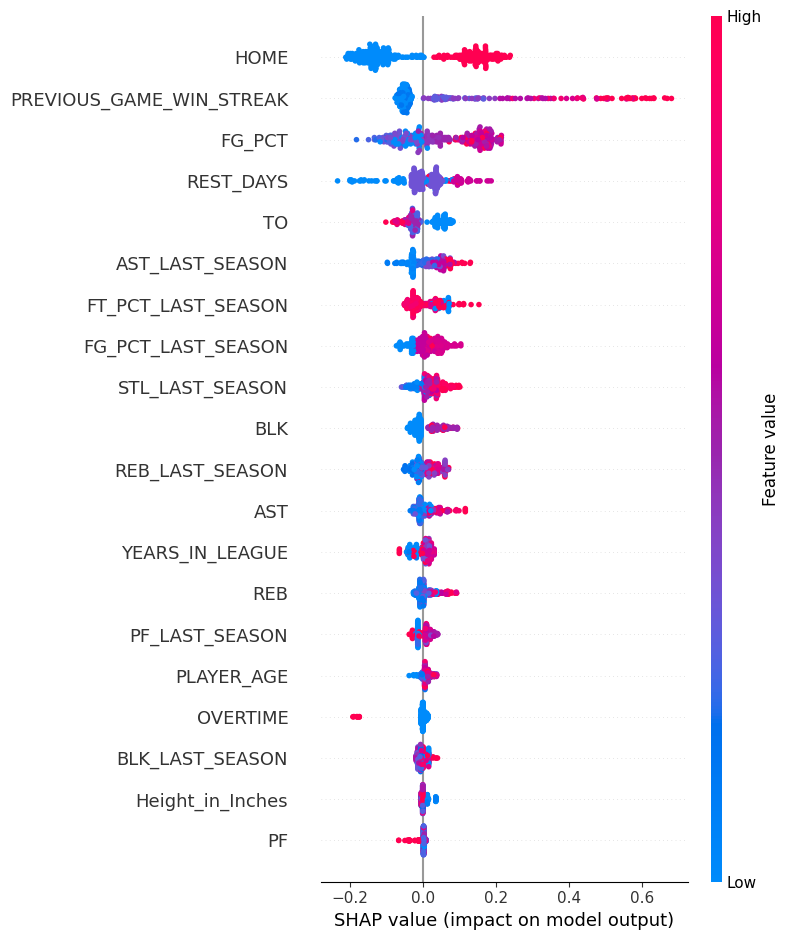

In [103]:
shap.summary_plot(shap_values5)

In [104]:
shap_values

.values =
array([[-0.09314245, -0.005525  , -0.1555269 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.22095137, -0.01926685, -0.22865188, ...,  0.        ,
         0.        ,  0.        ],
       [-0.09533499, -0.0026613 , -0.08735819, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.0084099 , -0.0008509 ,  0.38529287, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00608626, -0.0008509 ,  0.35402535, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03642939, -0.0008509 ,  0.32559238, ...,  0.        ,
         0.        ,  0.        ]])

.base_values =
array([-0.12524363, -0.12524363, -0.12524363, -0.12524363, -0.12524363,
       -0.12524363, -0.12524363, -0.12524363, -0.12524363, -0.12524363,
       -0.12524363, -0.12524363, -0.12524363, -0.12524363, -0.12524363,
       -0.12524363, -0.12524363, -0.12524363, -0.12524363, -0.12524363,
       -0.12524363, -0.12524363, -0.12524363, -0.12524363, -0.12524363,
 

In [118]:
shap_values_seed1 = pd.DataFrame({'variable': shap_values.feature_names, 'shap_values1': shap_values[0].values})
shap_values_seed2 = pd.DataFrame({'variable': shap_values2.feature_names, 'shap_values2': shap_values2[0].values})
shap_values_seed3 = pd.DataFrame({'variable': shap_values3.feature_names, 'shap_values3': shap_values3[0].values})
shap_values_seed4 = pd.DataFrame({'variable': shap_values4.feature_names, 'shap_values4': shap_values4[0].values})
shap_values_seed5 = pd.DataFrame({'variable': shap_values5.feature_names, 'shap_values5': shap_values5[0].values})


In [119]:
all_shap_values = shap_values_seed1.merge(shap_values_seed2, on='variable', how='left') \
         .merge(shap_values_seed3, on='variable', how='left') \
         .merge(shap_values_seed4, on='variable', how='left') \
         .merge(shap_values_seed5, on='variable', how='left')

all_shap_values['mean_shap_values'] = all_shap_values[['shap_values1','shap_values2','shap_values3','shap_values4','shap_values5']].mean(axis = 1)
all_shap_values['median_shap_values'] = all_shap_values[['shap_values1','shap_values2','shap_values3','shap_values4','shap_values5']].median(axis = 1)
all_shap_values

,variable,shap_values1,shap_values2,shap_values3,shap_values4,shap_values5,mean_shap_values,median_shap_values
0,HOME,-0.093,-0.063,-0.045,-0.045,-0.078,-0.065,-0.063
1,OVERTIME,-0.006,-0.009,-0.002,0.002,-0.002,-0.003,-0.002
2,REST_DAYS,-0.156,-0.057,-0.059,-0.050,-0.067,-0.078,-0.059
3,PREVIOUS_GAME_WIN_STREAK,-0.083,-0.049,-0.028,-0.042,-0.053,-0.051,-0.049
4,FG_PCT,-0.203,-0.085,-0.051,-0.065,-0.118,-0.104,-0.085
...,...,...,...,...,...,...,...,...
980,PLAYER_ID_1642439,0.000,0.000,0.000,0.000,0.000,0.000,0.000
981,PLAYER_ID_1642450,0.000,0.000,0.000,0.000,0.000,0.000,0.000
982,PLAYER_ID_1642461,0.000,0.000,0.000,0.000,0.000,0.000,0.000
983,PLAYER_ID_1642505,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [120]:
all_shap_values[0:25]

,variable,shap_values1,shap_values2,shap_values3,shap_values4,shap_values5,mean_shap_values,median_shap_values
0,HOME,-0.093,-0.063,-0.045,-0.045,-0.078,-0.065,-0.063
1,OVERTIME,-0.006,-0.009,-0.002,0.002,-0.002,-0.003,-0.002
2,REST_DAYS,-0.156,-0.057,-0.059,-0.050,-0.067,-0.078,-0.059
3,PREVIOUS_GAME_WIN_STREAK,-0.083,-0.049,-0.028,-0.042,-0.053,-0.051,-0.049
4,FG_PCT,-0.203,-0.085,-0.051,-0.065,-0.118,-0.104,-0.085
5,FT_PCT,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,REB,0.204,0.026,0.065,0.032,0.040,0.073,0.040
7,AST,0.187,0.013,0.049,0.023,0.073,0.069,0.049
8,STL,-0.011,0.001,0.000,0.000,-0.006,-0.003,0.000
9,BLK,-0.018,-0.003,-0.011,0.000,-0.022,-0.011,-0.011


In [121]:
all_shap_values.to_csv('xg_shap_value.csv', index=False)

In [122]:
from google.colab import files
files.download('xg_shap_value.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

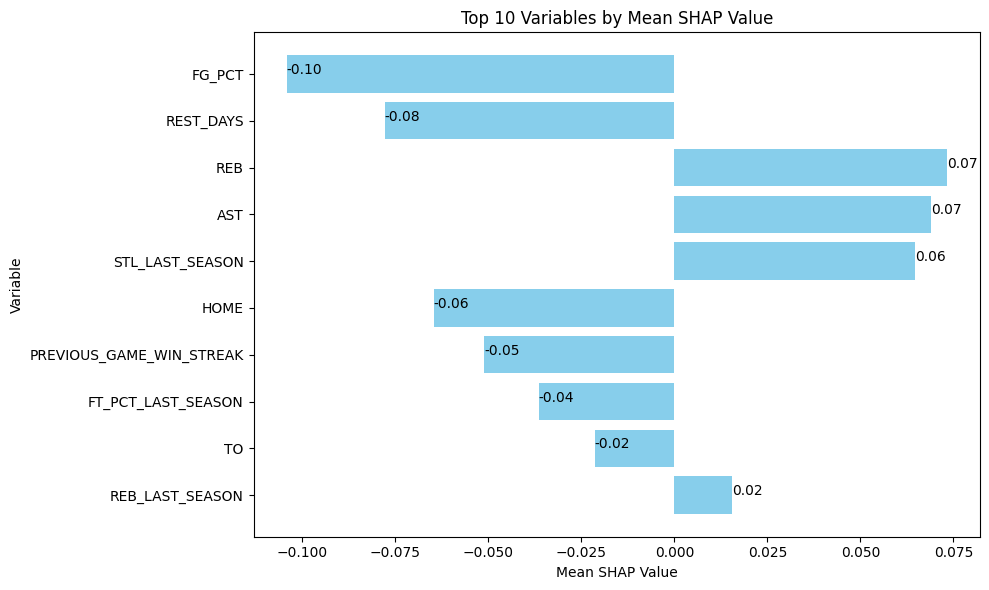

In [128]:
import matplotlib.pyplot as plt

# Sort by the absolute value of mean_shap_values in descending order
all_shap_values_sorted = all_shap_values.reindex(all_shap_values['mean_shap_values'].abs().sort_values(ascending=False).index)

# Select the top 10 variables
top_10_variables = all_shap_values_sorted.head(10)

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.barh(top_10_variables['variable'], top_10_variables['mean_shap_values'], color='skyblue')
plt.xlabel('Mean SHAP Value')
plt.ylabel('Variable')
plt.title('Top 10 Variables by Mean SHAP Value')

# Add data labels with 2 decimal places
for index, value in enumerate(top_10_variables['mean_shap_values']):
    plt.text(value, index, f'{value:.2f}')

plt.gca().invert_yaxis() #To show the highest value on top

plt.tight_layout()
plt.show()
